In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
results_dir = "Analyzer Results"

output_dir = "Tester Results"
os.makedirs(output_dir, exist_ok=True)

recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

In [3]:
# ...existing code...

dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    if key.endswith('_FIT'):
        dfs_fit[key] = pd.read_excel(file_path)
    else:
        dfs[key] = pd.read_excel(file_path)

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Raw dataframes: ['RESULTS', 'RESULTS_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_EXP', 'RESULTS_MT10', 'RESULTS_MTT', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_T10', 'RESULTS_TT', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_EXP', 'SegmentOrder']
Fit dataframes: ['RESULTS_FIT', 'RESULTS_MERGED_DATE_FIT', 'RESULTS_MERGED_EXP_FIT', 'RESULTS_MERGED_FIT', 'RESULTS_MT10_FIT', 'RESULTS_MTT_FIT', 'RESULTS_MTT_MERGED_DATE_FIT', 'RESULTS_MTT_MERGED_EXP_FIT', 'RESULTS_MTT_MERGED_FIT', 'RESULTS_T10_FIT', 'RESULTS_TT_FIT', 'RESULTS_TT_MERGED_DATE_FIT', 'RESULTS_TT_MERGED_EXP_FIT', 'RESULTS_TT_MERGED_FIT', 'SegmentOrder_FIT']
Found 15 raw and 15 fit dataframes in Analyzer Results.

Found 18 experiments, 9 variables and 4 parameters:
 ASR_control, gap_depth, tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50, offset_PPI_4, offset_PPI_6, offset_PPI_8, offset_PPI_10, offset_PPI_12, offset_P

---

In [4]:
# Count how many peakTime values are exactly 30 in RESULTS_MTT_MERGED (out of 324 )
import pandas as pd

df = dfs['RESULTS_MTT_MERGED']
count_30 = (df['peakTime'] == 30).sum()
print(f"Number of peakTime values equal to 30: {count_30}")

Number of peakTime values equal to 30: 129


---

Expectations:
- date fluctuations
- no repetition differences
- sex differences in strength metrics
- experiment differences, in particular with increased gap / offset

---

## Average Reaction Time

In [5]:
# Test if the average reaction time (excluding outliers) is significantly higher than the range 6-8

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MTT_MERGED']
vals = df['reactionTime'].dropna()

# Exclude outliers using IQR
q1 = vals.quantile(0.25)
q3 = vals.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
filtered = vals[(vals >= lower) & (vals <= upper)]

# Test against the upper bound (8)
stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
# Test against the lower bound (6)
stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')

print(f"Mean reaction time (IQR filtered): {filtered.mean():.2f}")
print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")

if p_8 < 0.05:
    print("Reaction time is significantly higher than 8.")
elif p_6 < 0.05:
    print("Reaction time is significantly higher than 6.")
else:
    print("Reaction time is not significantly higher than 6 or 8.")

Mean reaction time (IQR filtered): 10.68
T-test vs 8: statistic=46.840, p-value=1.525e-144
T-test vs 6: statistic=81.796, p-value=5.269e-215
Reaction time is significantly higher than 8.


In [6]:
# Test if the average peak time (excluding outliers) is significantly higher than the range 6-8, split by sex

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MTT_MERGED']

for sex in df['sex'].unique():
    vals = df[df['sex'] == sex]['reactionTime'].dropna()
    # Exclude outliers using IQR
    q1 = vals.quantile(0.25)
    q3 = vals.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = vals[(vals >= lower) & (vals <= upper)]
    # Test against the upper bound (8)
    stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
    # Test against the lower bound (6)
    stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')
    print(f"\nSex: {sex}")
    print(f"Mean peak time (IQR filtered): {filtered.mean():.2f}")
    print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
    print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")
    if p_8 < 0.05:
        print("Reaction time is significantly higher than 8.")
    elif p_6 < 0.05:
        print("Reaction time is significantly higher than 6.")
    else:
        print("Reaction time is not significantly higher than 6 or 8.")


Sex: female
Mean peak time (IQR filtered): 10.87
T-test vs 8: statistic=33.486, p-value=1.090e-73
T-test vs 6: statistic=56.824, p-value=6.456e-107
Reaction time is significantly higher than 8.

Sex: male
Mean peak time (IQR filtered): 10.49
T-test vs 8: statistic=37.114, p-value=5.189e-79
T-test vs 6: statistic=66.941, p-value=4.633e-116
Reaction time is significantly higher than 8.


In [7]:
# Test if the average reaction time (excluding outliers) is significantly higher than the range 6-8

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MTT_MERGED']
vals = df['peakTime'].dropna()

# Exclude outliers using IQR
q1 = vals.quantile(0.25)
q3 = vals.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
filtered = vals[(vals >= lower) & (vals <= upper)]

# Test against the upper bound (8)
stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
# Test against the lower bound (6)
stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')

print(f"Mean peak time (IQR filtered): {filtered.mean():.2f}")
print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")

if p_8 < 0.05:
    print("Peak time is significantly higher than 8.")
elif p_6 < 0.05:
    print("Peak time is significantly higher than 6.")
else:
    print("Peak time is not significantly higher than 6 or 8.")

Mean peak time (IQR filtered): 30.30
T-test vs 8: statistic=722.894, p-value=0.000e+00
T-test vs 6: statistic=787.722, p-value=0.000e+00
Peak time is significantly higher than 8.


In [8]:
# Test if the average peak time (excluding outliers) is significantly higher than the range 6-8, split by sex

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MTT_MERGED']

for sex in df['sex'].unique():
    vals = df[df['sex'] == sex]['peakTime'].dropna()
    # Exclude outliers using IQR
    q1 = vals.quantile(0.25)
    q3 = vals.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = vals[(vals >= lower) & (vals <= upper)]
    # Test against the upper bound (8)
    stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
    # Test against the lower bound (6)
    stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')
    print(f"\nSex: {sex}")
    print(f"Mean peak time (IQR filtered): {filtered.mean():.2f}")
    print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
    print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")
    if p_8 < 0.05:
        print("Peak time is significantly higher than 8.")
    elif p_6 < 0.05:
        print("Peak time is significantly higher than 6.")
    else:
        print("Peak time is not significantly higher than 6 or 8.")


Sex: female
Mean peak time (IQR filtered): 30.21
T-test vs 8: statistic=788.526, p-value=7.464e-248
T-test vs 6: statistic=859.522, p-value=7.192e-253
Peak time is significantly higher than 8.

Sex: male
Mean peak time (IQR filtered): 30.11
T-test vs 8: statistic=268.469, p-value=1.173e-160
T-test vs 6: statistic=292.757, p-value=6.682e-165
Peak time is significantly higher than 8.


---

## Repetition Differences

In [9]:
# ...existing code...

# Test if the value changes over repetitions (trial order) for each variable in RESULTS_MTT (non-parametric)
import ast
from scipy.stats import kruskal

def test_repetition_effect(df, variables, max_reps=5, alpha=0.05):
    results = []
    for var in variables:
        # Convert string lists to actual lists if needed
        vals = df[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
        # Filter to rows that are lists and have enough length
        list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
        if list_rows.empty:
            continue
        # Find the minimum length across all lists (to avoid index errors)
        min_len = min(list_rows.apply(len))
        min_len = min(min_len, max_reps)
        # Gather values by repetition index
        rep_groups = []
        for i in range(min_len):
            group = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
            if len(group) > 1:
                rep_groups.append(group.values)
        if len(rep_groups) < 2:
            continue
        # Kruskal-Wallis test across repetitions
        stat, p = kruskal(*rep_groups)
        if p < alpha:
            mean_diff = np.mean(rep_groups[0]) - np.mean(rep_groups[-1])
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': 'kruskal', 'mean_diff': mean_diff})
    return pd.DataFrame(results)

repetition_effects = test_repetition_effect(dfs['RESULTS_MTT'], variables)
test_repetition = pd.DataFrame(repetition_effects)


print(test_repetition) if not repetition_effects.empty else print("No significant repetition effects found for any variable.")
test_repetition.to_excel(os.path.join(output_dir, "TEST_REPETITION.xlsx"), index=False)

No significant repetition effects found for any variable.


# ---> merge across repetitions

---

## Intratrial Differences

In [10]:
# Check for intratrial differences: do variables increase or decrease across one animal's experiment?

import pandas as pd
from scipy.stats import linregress

# Load the lookup table DataFrame (assume it's named "SegmentOrder.xlsx" and in Analyzer Results)
lookup_path = os.path.join("Peakfinder Results", "SegmentOrder.xlsx")
lookup_df = pd.read_excel(lookup_path)

# Load main results
df = dfs['RESULTS_MTT_MERGED']

# For each animal and date, check variable trends across experiment order
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
trend_results = []

# ...existing code...

for (animal, date), group in lookup_df.groupby(['animal', 'date']):
    order_map = {row['experiment']: row['order_index'] for _, row in group.iterrows()}
    df_sub = df[(df['animal'] == animal) & (df['date'] == date)].copy()
    df_sub['order_index'] = df_sub['experiment'].map(order_map)
    df_sub = df_sub[df_sub['order_index'].notnull()]
    df_sub = df_sub.sort_values('order_index')
    n_trials = len(df_sub)
    for var in variables:
        vals = df_sub[var].dropna()
        order = df_sub['order_index'].loc[vals.index]
        if len(vals) > 1:
            slope, intercept, r, p, _ = linregress(order, vals)
            # Percent change per minute
            start = vals.iloc[0]
            end = vals.iloc[-1]
            percent_change = ((end - start) / start) * 100 if start != 0 else None
            percent_change_per_minute = percent_change / 30 if percent_change is not None else None
            trend_results.append({
                'animal': animal,
                'date': date,
                'variable': var,
                'slope_per_trial': slope,
                'r': r,
                'p': p,
                'direction': 'increase' if slope > 0 else 'decrease' if slope < 0 else 'none',
                'percent_change': percent_change,
                'percent_change_per_minute': percent_change_per_minute
            })

# ...existing code...

trend_df = pd.DataFrame(trend_results)
trend_df = trend_df[trend_df['p'] < 0.05].reset_index(drop=True)  # Only keep significant results

print(trend_df)
trend_df.to_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT.xlsx"), index=False)
# ...existing code...

      animal     date      variable  slope_per_trial         r         p  \
0    Animal1  April16           tau        -0.628523 -0.469065  0.049564   
1   Animal15   June26    difference        -0.150698 -0.476009  0.045843   
2    Animal2   June26  reactionTime        -0.010675 -0.500549  0.034370   
3    Animal2    May20           tau         0.811059  0.543683  0.019691   
4    Animal4   June26           tau         0.810639  0.501556  0.033952   
5    Animal4    May20     peakValue         0.684392  0.481530  0.043039   
6    Animal4    May20          PTPA         0.690802  0.482848  0.042389   
7    Animal4    May20          PTTA         0.636672  0.490890  0.038586   
8    Animal4    May20           RMS         0.196448  0.487877  0.039979   
9    Animal6  April16  reactionTime         0.025215  0.562720  0.015049   
10   Animal6  April16           RMS        -0.146092 -0.495251  0.036636   
11   Animal6  April16           AUC       -40.141711 -0.506415  0.031988   

   directio

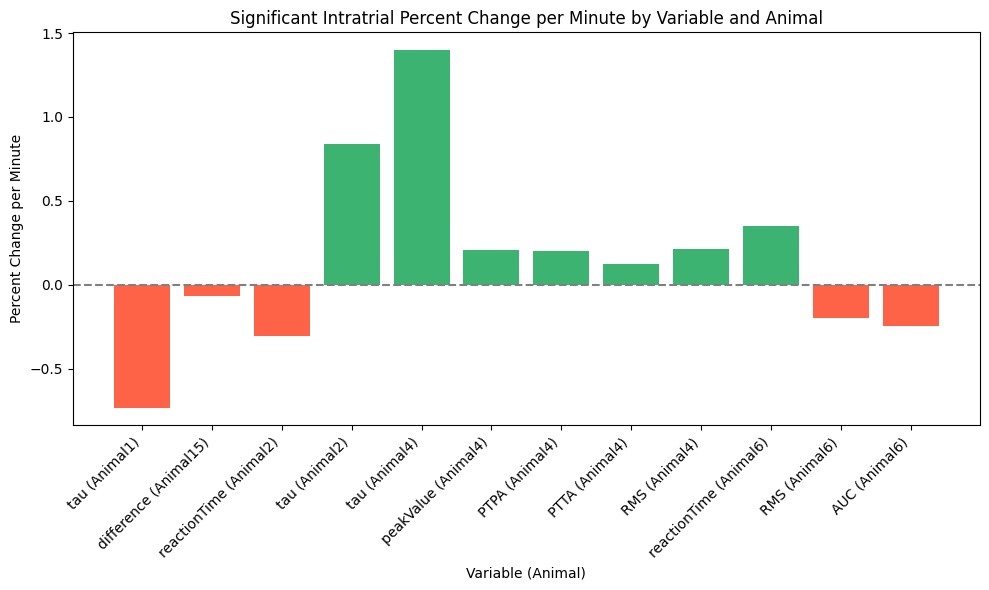

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load significant intratrial trends (trend_df)
trend_df = pd.read_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT.xlsx"))

# Plot percent_change_per_minute by variable and animal, colored by direction
plt.figure(figsize=(10, 6))
colors = trend_df['direction'].map({'increase': 'mediumseagreen', 'decrease': 'tomato', 'none': 'gray'})
labels = trend_df['variable'] + " (" + trend_df['animal'] + ")"
plt.bar(labels, trend_df['percent_change_per_minute'], color=colors)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('Percent Change per Minute')
plt.xlabel('Variable (Animal)')
plt.title('Significant Intratrial Percent Change per Minute by Variable and Animal')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd

# Load significant intratrial trends
trend_df = pd.read_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT.xlsx"))

# Define metrics
strength_metrics = ['AUC', 'PTPA', 'PTTA', 'RMS', 'peakValue']
reaction_metrics = ['reactionTime', 'peakTime']

# Only keep strength metrics
trend_strength = trend_df[trend_df['variable'].isin(strength_metrics)]
avg_strength_percent_change_per_minute = trend_strength['percent_change_per_minute'].mean()
print(f"Average percent change per minute (strength metrics, significant results): {avg_strength_percent_change_per_minute:.3f}")

# Only keep reaction metrics
trend_reaction = trend_df[trend_df['variable'].isin(reaction_metrics)]
avg_reaction_percent_change_per_minute = trend_reaction['percent_change_per_minute'].mean()
print(f"Average percent change per minute (reaction metrics, significant results): {avg_reaction_percent_change_per_minute:.3f}")

Average percent change per minute (strength metrics, significant results): 0.050
Average percent change per minute (reaction metrics, significant results): 0.023


| Animal    | Date     | Variable      | Slope/Trial   | r         | p-value   | Direction | % Change    | % Change/Min |
|-----------|----------|---------------|---------------|-----------|-----------|-----------|-------------|--------------|
| Animal1   | April16  | tau           | -0.628523     | -0.469065 | 0.049564  | decrease  | -21.98      | -0.73        |
| Animal6   | April16  | reactionTime  |  0.025215     |  0.562720 | 0.015049  | increase  |  10.48      |  0.35        |
| Animal6   | April16  | RMS           | -0.146092     | -0.495251 | 0.036636  | decrease  |  -5.99      | -0.20        |
| Animal6   | April16  | AUC           | -40.141711    | -0.506415 | 0.031988  | decrease  |  -7.39      | -0.25        |
| Animal2   | May20    | tau           |  0.811059     |  0.543683 | 0.019691  | increase  |  25.10      |  0.84        |
| Animal4   | May20    | peakValue     |  0.684392     |  0.481530 | 0.043039  | increase  |   6.13      |  0.20        |
| Animal4   | May20    | PTPA          |  0.690802     |  0.482848 | 0.042389  | increase  |   6.11      |  0.20        |
| Animal4   | May20    | PTTA          |  0.636672     |  0.490890 | 0.038586  | increase  |   3.75      |  0.12        |
| Animal4   | May20    | RMS           |  0.196448     |  0.487877 | 0.039979  | increase  |   6.43      |  0.21        |
| Animal4   | May20    | percentPPI    | -0.335797     | -0.496195 | 0.042781  | decrease  | -44.18      | -1.47        |
| Animal2   | June26   | reactionTime  | -0.010675     | -0.500549 | 0.034370  | decrease  |  -9.09      | -0.30        |
| Animal2   | June26   | percentPPI    | -0.257872     | -0.492331 | 0.044683  | decrease  | -86.65      | -2.89        |
| Animal4   | June26   | tau           |  0.810639     |  0.501556 | 0.033952  | increase  |  41.93      |  1.40        |
| Animal15  | June26   | difference    | -0.150698     | -0.476009 | 0.045843  | decrease  |  -2.00      | -0.07        |


---

## Date Differences

In [13]:
# ...existing code...

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

date_results = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in variables:
        # Non-parametric Kruskal-Wallis for all metrics
        groups = [group[var].dropna().values for _, group in df_sex.groupby('date')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None
            if p < 0.05:
                try:
                    dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='date', p_adjust='bonferroni')
                    min_p = dunn.replace(0, float('nan')).min().min()
                    idx = dunn.stack().idxmin()
                    date1, date2 = idx
                    vals1 = df_sex[df_sex['date'] == date1][var].dropna()
                    vals2 = df_sex[df_sex['date'] == date2][var].dropna()
                    u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                    n1, n2 = len(vals1), len(vals2)
                    eff = 1 - (2 * u) / (n1 * n2)
                    mean_diff = vals1.mean() - vals2.mean()
                    posthoc_p = min_p
                    posthoc_test = "Dunn"
                except Exception:
                    posthoc_p, posthoc_test, mean_diff = None, "Dunn", None
        else:
            stat, p, posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None, None, None
        date_results.append({
            'sex': sex,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p is not None and p < 0.05,
            'posthoc_p': posthoc_p,
            'posthoc_test': posthoc_test,
            'date1': date1,
            'date2': date2,
            'effect_strength': eff,
            'mean_diff': mean_diff
        })

test_date = pd.DataFrame(date_results)
print(test_date)

test_date.to_excel(os.path.join(output_dir, "TEST_DATE.xlsx"), index=False)
# ...existing code...

       sex      variable       stat             p  significant     posthoc_p  \
0   female  reactionTime  43.708603  3.226989e-10         True  3.220414e-10   
1   female      peakTime   6.581660  3.722294e-02         True  5.041759e-02   
2   female    difference  41.645550  9.052816e-10         True  4.855321e-08   
3   female     peakValue  69.978420  6.373516e-16         True  2.539041e-15   
4   female          PTPA  69.819235  6.901537e-16         True  2.880680e-15   
5   female          PTTA  66.354571  3.902006e-15         True  2.255802e-14   
6   female           RMS  73.479479  1.106965e-16         True  2.548253e-16   
7   female           tau   3.371776  1.852799e-01        False           NaN   
8   female           AUC  92.456782  8.380404e-21         True  8.009213e-21   
9     male  reactionTime   6.049538  4.856904e-02         True  4.532128e-02   
10    male      peakTime   7.310487  2.585519e-02         True  5.618624e-02   
11    male    difference   1.652426  4.3

In [14]:
# ...existing code...

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

date_results_merged_sex = []

for var in variables:
    # Non-parametric Kruskal-Wallis for all metrics, merged by sex
    groups = [group[var].dropna().values for _, group in df.groupby('date')]
    groups = [g for g in groups if len(g) > 1]
    stat, p, posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None, None, None
    if len(groups) > 1:
        stat, p = kruskal(*groups)
        if p < 0.05:
            try:
                dunn = sp.posthoc_dunn(df, val_col=var, group_col='date', p_adjust='bonferroni')
                min_p = dunn.replace(0, float('nan')).min().min()
                idx = dunn.stack().idxmin()
                date1, date2 = idx
                vals1 = df[df['date'] == date1][var].dropna()
                vals2 = df[df['date'] == date2][var].dropna()
                u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                n1, n2 = len(vals1), len(vals2)
                eff = 1 - (2 * u) / (n1 * n2)
                mean_diff = vals1.mean() - vals2.mean()
                posthoc_p = min_p
                posthoc_test = "Dunn"
            except Exception:
                posthoc_p, posthoc_test, mean_diff = None, "Dunn", None
    date_results_merged_sex.append({
        'variable': var,
        'stat': stat,
        'p': p,
        'significant': p is not None and p < 0.05,
        'posthoc_p': posthoc_p,
        'posthoc_test': posthoc_test,
        'date1': date1,
        'date2': date2,
        'effect_strength': eff,
        'mean_diff': mean_diff
    })

test_date_merged_sex = pd.DataFrame(date_results_merged_sex)
print(test_date_merged_sex)

test_date_merged_sex.to_excel(os.path.join(output_dir, "TEST_DATE_MERGED_SEX.xlsx"), index=False)
# ...existing code...

       variable       stat             p  significant     posthoc_p  \
0  reactionTime  37.506334  7.171386e-09         True  2.859003e-08   
1      peakTime   3.974008  1.371056e-01        False           NaN   
2    difference  10.267221  5.895236e-03         True  7.796005e-03   
3     peakValue  46.523577  7.898302e-11         True  5.939417e-10   
4          PTPA  46.417149  8.329985e-11         True  6.748200e-10   
5          PTTA  46.028476  1.011681e-10         True  1.046510e-09   
6           RMS  43.351703  3.857423e-10         True  3.510741e-10   
7           tau   7.343976  2.542587e-02         True  2.354938e-02   
8           AUC  55.774500  7.739647e-13         True  2.674751e-13   

  posthoc_test    date1   date2  effect_strength    mean_diff  
0         Dunn  April16  June26        -0.451732     0.769444  
1         None     None    None              NaN          NaN  
2         Dunn  April16  June26         0.209019    -0.574383  
3         Dunn  April16  June26  

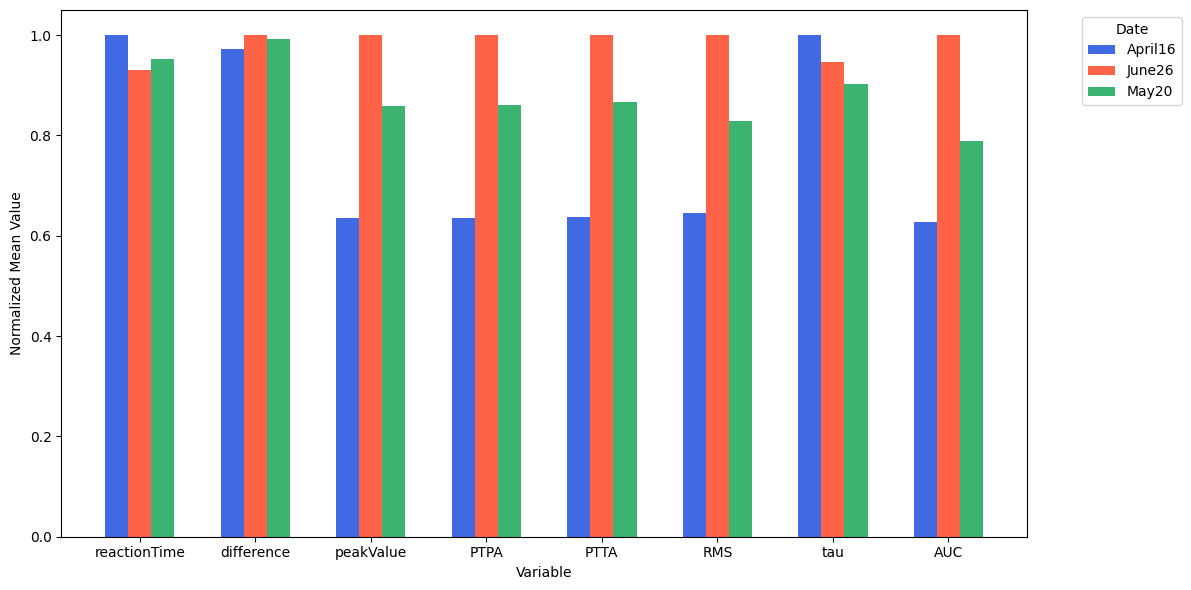

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your results and raw data
test_date_merged_sex = pd.read_excel(os.path.join(output_dir, "TEST_DATE_MERGED_SEX.xlsx"))
df = dfs['RESULTS_MTT_MERGED']

# Only keep significant results
sig = test_date_merged_sex[test_date_merged_sex['significant'] == True]

# Get all unique dates and variables
dates = df['date'].unique()
variables = sig['variable'].unique()

# Prepare data: mean raw value for each variable/date
bar_data = []
for var in variables:
    means = []
    for date in dates:
        vals = df[df['date'] == date][var].dropna()
        means.append(vals.mean())
    # Normalize to [-1, 1] for each variable
    max_abs = np.max(np.abs(means))
    means_norm = [m / max_abs if max_abs != 0 else 0 for m in means]
    bar_data.append(means_norm)
bar_data = np.array(bar_data)  # shape: (variables, dates)



# Plot layered/grouped bar plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(variables))
colors = ['royalblue', 'tomato', 'mediumseagreen'][:len(dates)]

for i, date in enumerate(dates):
    ax.bar(x + i*bar_width, bar_data[:, i], width=bar_width, label=date, color=colors[i])

ax.set_xticks(x + bar_width)
ax.set_xticklabels(variables)
ax.set_ylabel('Normalized Mean Value')
ax.set_xlabel('Variable')
ax.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

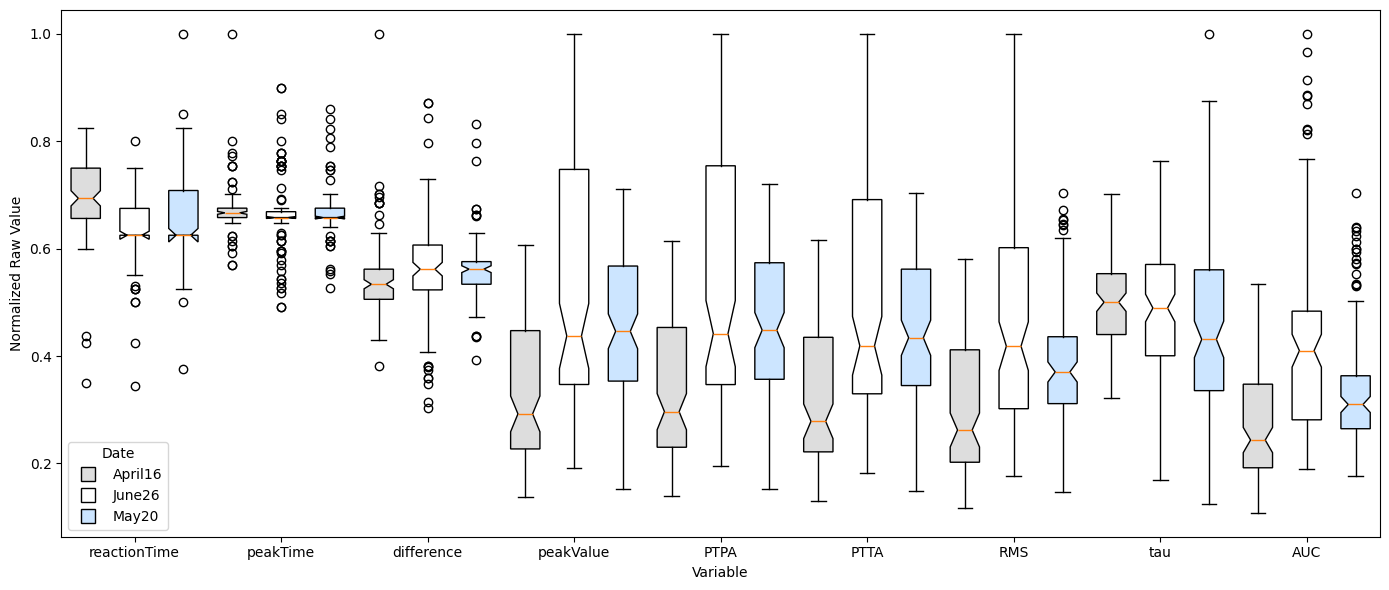

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your results and raw data
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE.xlsx"))
df = dfs['RESULTS_MTT_MERGED']

# Only keep significant results
sig = test_date#[test_date['significant'] == True]

# Get all unique dates and variables
dates = df['date'].unique()
variables = sig['variable'].unique()

# Prepare data for boxplot: raw values for each variable/date
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, date in enumerate(dates):
        vals = df[df['date'] == date][var].dropna()
        # Normalize to [-1, 1] for each variable
        max_abs = np.max(np.abs(df[var].dropna()))
        vals_norm = vals / max_abs if max_abs != 0 else vals
        data.append(vals_norm)
        positions.append(i*len(dates) + j)
        labels.append(f"{var}" if j == 0 else "")  # Only label once per variable
        box_colors.append(['#DDDDDD', '#FFFFFF', '#CCE5FF', '#FFCCCC', '#CCFFCC'][j % 5])  # Color by date

plt.figure(figsize=(14, 6))
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

plt.xticks([i*len(dates)+(len(dates)-1)/2 for i in range(len(variables))], variables)
plt.ylabel('Normalized Raw Value')
plt.xlabel('Variable')
plt.legend(handles=[
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#DDDDDD', label=dates[0], linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#FFFFFF', label=dates[1], linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#CCE5FF', label=dates[2], linestyle='None')
], title='Date', loc='lower left')
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd

df = dfs['RESULTS_MTT_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date']]

# Calculate mean for each variable, grouped by date and sex
mean_table = df.groupby(['date', 'sex'])[variables].mean().reset_index()

print(mean_table)

# Optionally, save to Excel
mean_table.to_excel(os.path.join(output_dir, "MEAN_VARIABLES_BY_DATE_SEX.xlsx"), index=False)

      date     sex  reactionTime   peakTime  difference   peakValue  \
0  April16  female     11.572222  30.257407   18.685185   63.287037   
1  April16    male     10.525926  30.991358   20.465432  124.366667   
2   June26  female     10.141358  30.846296   20.704938  106.338272   
3   June26    male     10.417901  30.012346   19.594444  189.194753   
4    May20  female     10.725309  31.142593   20.417284   95.199691   
5    May20    male     10.306790  29.835802   19.529012  158.548148   

         PTPA        PTTA        RMS         tau           AUC  
0   63.630685   56.873657  25.027630  156.781444   6587.655917  
1  123.826577  112.153586  50.195299  135.166293  12396.977306  
2  106.167170   95.063349  44.510117  159.495160  12789.907951  
3  188.679392  170.262756  71.931599  116.880358  17450.135602  
4   95.298627   86.131957  38.205722  156.964728  10035.441201  
5  158.559985  143.964136  58.337818  106.667259  13797.943688  


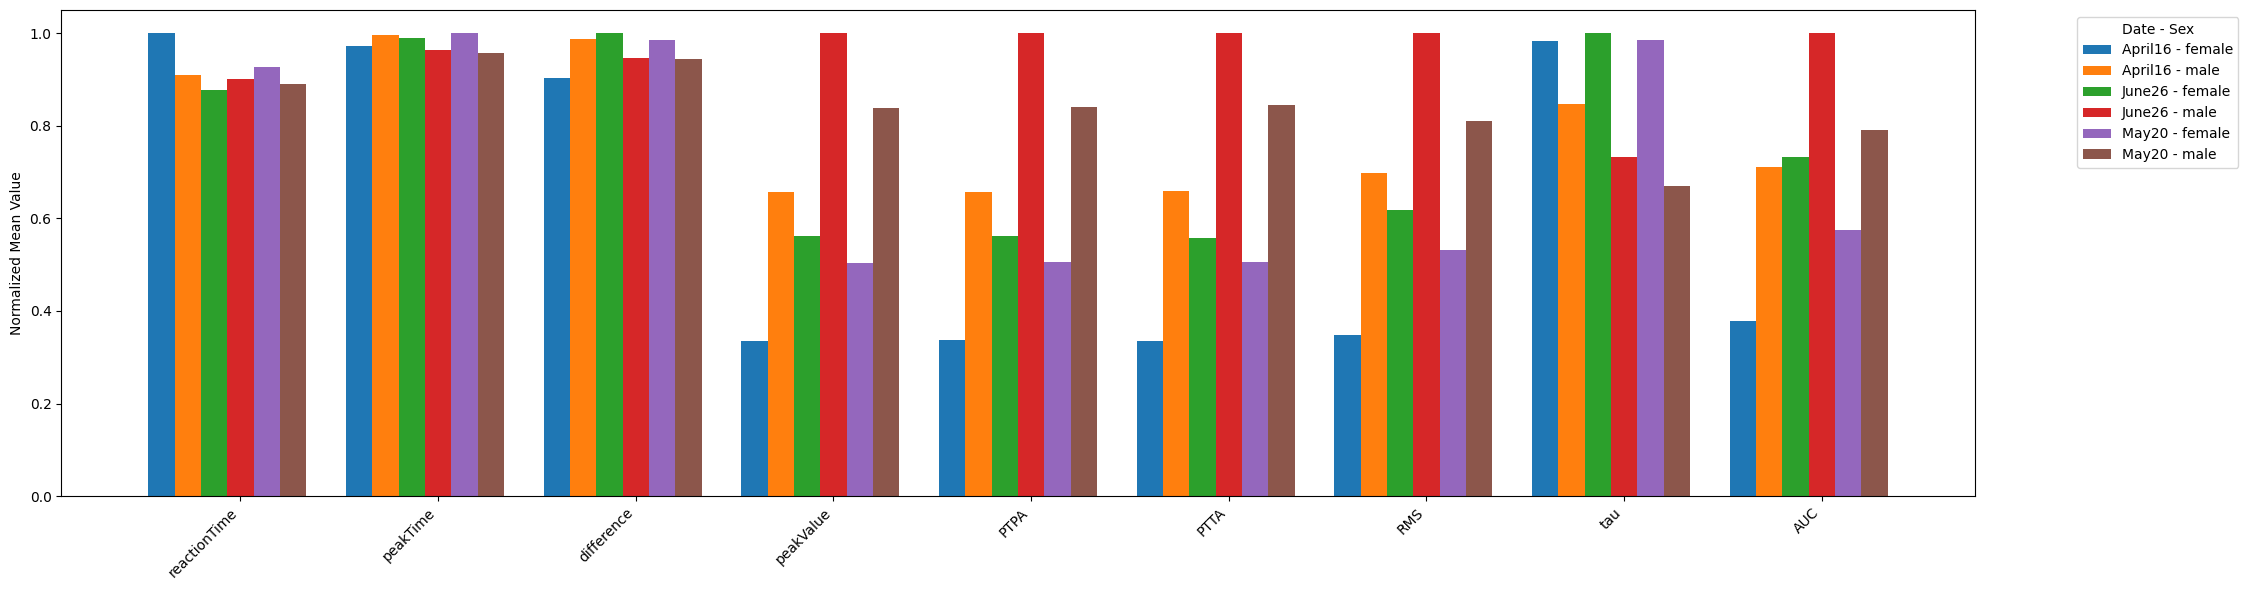

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume mean_table is already loaded
variables = [col for col in mean_table.columns if col not in ['date', 'sex']]
dates = mean_table['date'].unique()
sexes = mean_table['sex'].unique()

# Normalize each variable to [-1, 1] across all date-sex groups
norm_means = []
for var in variables:
    vals = mean_table[var].values
    max_abs = np.max(np.abs(vals))
    norm_vals = vals / max_abs if max_abs != 0 else vals
    norm_means.append(norm_vals)
norm_means = np.array(norm_means).T  # shape: (groups, variables)

# Prepare bar positions
n_groups = len(mean_table)
n_vars = len(variables)
bar_width = 0.8 / n_groups
x = np.arange(n_vars)

fig, ax = plt.subplots(figsize=(2.5*n_vars, 6))

for i in range(n_groups):
    label = f"{mean_table.loc[i, 'date']} - {mean_table.loc[i, 'sex']}"
    ax.bar(x + i*bar_width, norm_means[i], width=bar_width, label=label)

ax.set_xticks(x + bar_width * n_groups / 2)
ax.set_xticklabels(variables, rotation=45, ha='right')
ax.set_ylabel('Normalized Mean Value')
ax.legend(title='Date - Sex', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd

df = dfs['RESULTS_MTT_MERGED']
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']

# Calculate mean for each metric by date
mean_by_date = df.groupby('date')[strength_metrics].mean()

# Calculate mean difference between dates for each metric
mean_diff = mean_by_date.max() - mean_by_date.min()
mean_diff = mean_diff.rename('mean_difference')

# Combine for display
result = mean_by_date.T
result['mean_difference'] = mean_diff

print(result)

# Optionally save to Excel
result.to_excel(os.path.join(output_dir, "STRENGTH_METRIC_MEAN_DIFF_BY_DATE.xlsx"))

date           April16        June26         May20  mean_difference
peakValue    93.826852    147.766512    126.873920        53.939660
PTPA         93.728631    147.423281    126.929306        53.694650
PTTA         84.513622    132.663052    115.048046        48.149431
RMS          37.611465     58.220858     48.271770        20.609394
tau         145.973869    138.187759    131.815994        14.157875
AUC        9492.316611  15120.021776  11916.692444      5627.705165


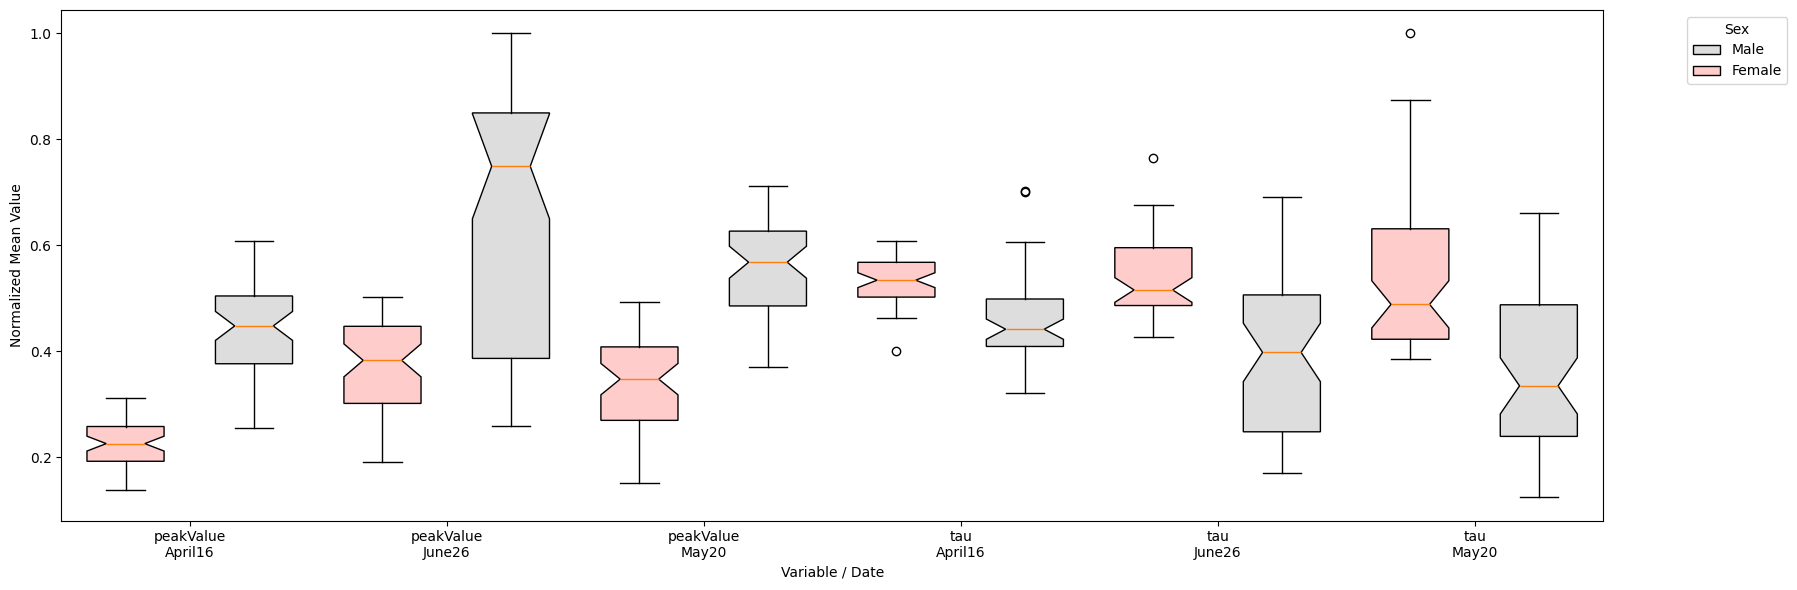

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your results and raw data
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE.xlsx"))
df = dfs['RESULTS_MTT_MERGED']

# Only keep significant results for strength metrics
strength_metrics = ['peakValue', 'tau']
sig = test_date[(test_date['significant'] == True) & (test_date['variable'].isin(strength_metrics))]

dates = df['date'].unique()
sexes = df['sex'].unique()
variables = sig['variable'].unique()

# Prepare data for boxplot: raw values for each variable/date/sex
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, date in enumerate(dates):
        for k, sex in enumerate(sexes):
            vals = df[(df['date'] == date) & (df['sex'] == sex)][var].dropna()
            # Normalize to [-1, 1] for each variable
            max_abs = np.max(np.abs(df[var].dropna()))
            vals_norm = vals / max_abs if max_abs != 0 else vals
            data.append(vals_norm)
            # Position: variable * (dates*sexes) + date * sexes + sex
            positions.append(i*len(dates)*len(sexes) + j*len(sexes) + k)
            # X tick label for each date
            labels.append(f"{date}" if k == 0 else "")
            # Color by sex
            box_colors.append('#DDDDDD' if sex == 'male' else '#FFCCCC')

plt.figure(figsize=(18, 6))
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

# X ticks: one per date per variable
xticks = []
xticklabels = []
for i in range(len(variables)):
    for j in range(len(dates)):
        pos = i*len(dates)*len(sexes) + j*len(sexes) + 0.5
        xticks.append(pos)
        xticklabels.append(f"{variables[i]}\n{dates[j]}")
plt.xticks(xticks, xticklabels)
plt.ylabel('Normalized Mean Value')
plt.xlabel('Variable / Date')

# Legend for sex
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(facecolor='#DDDDDD', edgecolor='black', label='Male'),
    mpatches.Patch(facecolor='#FFCCCC', edgecolor='black', label='Female'),
]
plt.legend(handles=legend_handles, title='Sex', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

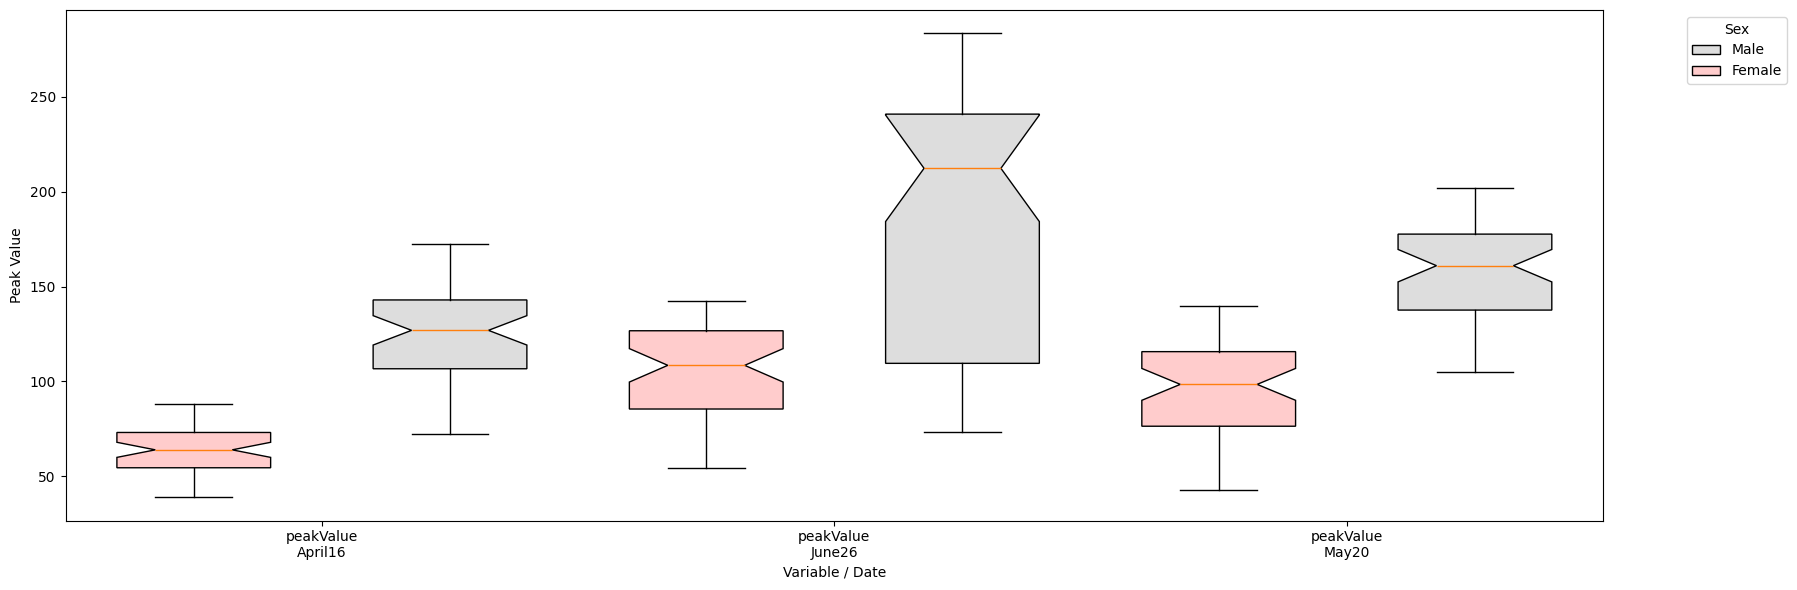

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load your results and raw data
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE.xlsx"))
df = dfs['RESULTS_MTT_MERGED']

# Only keep significant results for strength metrics
strength_metrics = ['peakValue']
sig = test_date[(test_date['significant'] == True) & (test_date['variable'].isin(strength_metrics))]

dates = df['date'].unique()
sexes = df['sex'].unique()
variables = sig['variable'].unique()

# Prepare data for boxplot: raw values for each variable/date/sex (NO normalization)
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, date in enumerate(dates):
        for k, sex in enumerate(sexes):
            vals = df[(df['date'] == date) & (df['sex'] == sex)][var].dropna()
            data.append(vals)
            # Position: variable * (dates*sexes) + date * sexes + sex
            positions.append(i*len(dates)*len(sexes) + j*len(sexes) + k)
            # X tick label for each date
            labels.append(f"{date}" if k == 0 else "")
            # Color by sex
            box_colors.append('#DDDDDD' if sex == 'male' else '#FFCCCC')

plt.figure(figsize=(18, 6))
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

# X ticks: one per date per variable
xticks = []
xticklabels = []
for i in range(len(variables)):
    for j in range(len(dates)):
        pos = i*len(dates)*len(sexes) + j*len(sexes) + 0.5
        xticks.append(pos)
        xticklabels.append(f"{variables[i]}\n{dates[j]}")
plt.xticks(xticks, xticklabels)
plt.ylabel('Peak Value')
plt.xlabel('Variable / Date')

# Legend for sex
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(facecolor='#DDDDDD', edgecolor='black', label='Male'),
    mpatches.Patch(facecolor='#FFCCCC', edgecolor='black', label='Female'),
]
plt.legend(handles=legend_handles, title='Sex', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [22]:
# Count how many sex/variable groups show significant date deviations

import pandas as pd
from scipy.stats import kruskal

df = dfs['RESULTS_MTT_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

significant_count = 0
results = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in variables:
        groups = [group[var].dropna().values for _, group in df_sex.groupby('date')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            if p < 0.05:
                significant_count += 1
                results.append({'sex': sex, 'variable': var, 'stat': stat, 'p': p})

print(f"Number of sex/variable groups with significant date deviations: {significant_count}")
pd.DataFrame(results).to_excel(os.path.join(output_dir, "SIGNIFICANT_DATE_SPLIT.xlsx"), index=False)

Number of sex/variable groups with significant date deviations: 16


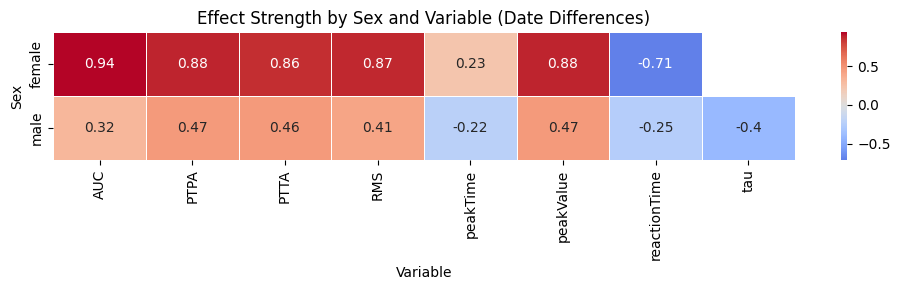

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Paste your results as a DataFrame
data = {
    "sex": ["female"]*8 + ["male"]*8,
    "variable": ["AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau",
                 "AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau"],
    "effect_strength": [0.940329, 0.877915, 0.859396, 0.871742, 0.229424, 0.878944, -0.711248, np.nan,
                       0.316187, 0.466392, 0.463649, 0.414952, -0.223594, 0.467078, -0.247942, -0.403978]
}
df = pd.DataFrame(data)

# Pivot for heatmap (sex x variable)
heatmap_data = df.pivot(index="sex", columns="variable", values="effect_strength")

plt.figure(figsize=(10, 3))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Sex and Variable (Date Differences)")
plt.ylabel("Sex")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()

## Summary of Date Differences (Non-parametric Tests)

All results use the **Kruskal-Wallis test** for date effects, with **Dunn's post hoc** for pairwise comparison.  
Effect strength is rank-biserial correlation.  
Mean difference is (date1 mean - date2 mean) for the most significant pair.

| Sex    | Variable      | Stat     | p-value    | Significant | Posthoc p   | Posthoc Test | Date1    | Date2    | Effect Strength | Mean Diff    |
|--------|--------------|----------|------------|-------------|-------------|--------------|----------|----------|-----------------|-------------|
| female | reactionTime | 43.71    | 3.23e-10   | True        | 3.22e-10    | Dunn         | April16  | June26   | -0.71           | 1.43        |
| female | peakTime     | 6.58     | 3.72e-02   | True        | 5.04e-02    | Dunn         | June26   | May20    | 0.23            | -0.30       |
| female | difference   | 41.65    | 9.05e-10   | True        | 4.86e-08    | Dunn         | April16  | June26   | 0.59            | -2.02       |
| female | peakValue    | 69.98    | 6.37e-16   | True        | 2.54e-15    | Dunn         | April16  | June26   | 0.88            | -43.05      |
| female | PTPA         | 69.82    | 6.90e-16   | True        | 2.88e-15    | Dunn         | April16  | June26   | 0.88            | -42.54      |
| female | PTTA         | 66.35    | 3.90e-15   | True        | 2.26e-14    | Dunn         | April16  | June26   | 0.86            | -38.19      |
| female | RMS          | 73.48    | 1.11e-16   | True        | 2.55e-16    | Dunn         | April16  | June26   | 0.87            | -19.48      |
| female | tau          | 3.37     | 0.185      | False       | NaN         | None         | None     | None     | NaN             | NaN         |
| female | AUC          | 92.46    | 8.38e-21   | True        | 8.01e-21    | Dunn         | April16  | June26   | 0.94            | -6202.25    |
| female | percentPPI   | 0.000045 | 1.00       | False       | NaN         | None         | None     | None     | NaN             | NaN         |
| male   | reactionTime | 6.05     | 4.86e-02   | True        | 4.53e-02    | Dunn         | April16  | May20    | -0.25           | 0.22        |
| male   | peakTime     | 7.31     | 2.59e-02   | True        | 5.62e-02    | Dunn         | April16  | June26   | -0.22           | 0.98        |
| male   | difference   | 1.65     | 0.438      | False       | NaN         | None         | None     | None     | NaN             | NaN         |
| male   | peakValue    | 34.53    | 3.18e-08   | True        | 4.55e-08    | Dunn         | April16  | June26   | 0.47            | -64.83      |
| male   | PTPA         | 35.12    | 2.36e-08   | True        | 3.71e-08    | Dunn         | April16  | June26   | 0.47            | -64.85      |
| male   | PTTA         | 35.43    | 2.02e-08   | True        | 3.87e-08    | Dunn         | April16  | June26   | 0.46            | -58.11      |
| male   | RMS          | 16.25    | 2.96e-04   | True        | 1.71e-04    | Dunn         | April16  | June26   | 0.41            | -21.74      |
| male   | tau          | 13.65    | 1.09e-03   | True        | 8.54e-04    | Dunn         | April16  | May20    | -0.40           | 28.50       |
| male   | AUC          | 8.07     | 1.77e-02   | True        | 1.69e-02    | Dunn         | April16  | June26   | 0.32            | -5053.16    |
| male   | percentPPI   | 0.000060 | 1.00       | False       | NaN         | None         | None     | None     | NaN             | NaN         |

**Interpretation:**
- **Females:** Significant date effects for all metrics except tau and percentPPI. Largest differences are between April16 and June26, with very large effect strengths for strength metrics (peakValue, PTPA, PTTA, RMS, AUC).
- **Males:** Significant date effects for all metrics except difference and percentPPI. Most pronounced for peakValue, PTPA, PTTA, RMS, tau, and AUC (April16 vs June26 or May20), with moderate to large effect strengths.
- **Conclusion:** Date (batch/day) strongly impacts most metrics for both sexes, especially strength metrics. Always control for date in analysis.

In [24]:
# Calculate average effect strength for date differences, split by sex

import pandas as pd

# Load your results (replace with actual path if needed)
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE.xlsx"))

# Only keep significant results
sig = test_date[test_date['significant'] == True]

# Calculate average effect strength for each sex
avg_female = sig[sig['sex'] == 'female']['effect_strength'].mean()
avg_male = sig[sig['sex'] == 'male']['effect_strength'].mean()

# Calculate how much stronger the effect is for females
strength_ratio = avg_female / avg_male if avg_male != 0 else None
strength_diff = avg_female - avg_male

print(f"Average effect strength (female): {avg_female:.3f}")
print(f"Average effect strength (male): {avg_male:.3f}")
print(f"Females have {strength_ratio:.2f}x stronger effect on average (ratio), or {strength_diff:.3f} higher (difference).")

Average effect strength (female): 0.567
Average effect strength (male): 0.157
Females have 3.62x stronger effect on average (ratio), or 0.410 higher (difference).


# ---> split by date, especially for females (may be estrous cycle?)

---

In [25]:
# ...existing code...

import pandas as pd
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

sex_diff_results = []

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    for var in variables:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        mean_diff = vals_male.mean() - vals_female.mean() if len(vals_male) > 0 and len(vals_female) > 0 else None
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
            n1, n2 = len(vals_male), len(vals_female)
            u, _ = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
            eff = 1 - (2 * u) / (n1 * n2)
            # Dunn's posthoc
            try:
                data = pd.DataFrame({var: pd.concat([vals_male, vals_female]),
                                    'group': ['male'] * len(vals_male) + ['female'] * len(vals_female)})
                dunn = sp.posthoc_dunn(data, val_col=var, group_col='group', p_adjust='bonferroni')
                posthoc_p = dunn.loc['male', 'female']
                posthoc_test = "Dunn"
            except Exception:
                posthoc_p = None
                posthoc_test = "Dunn"
        else:
            stat, p, eff, posthoc_p, posthoc_test = None, None, None, None, None
        sex_diff_results.append({
            'date': date,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p is not None and p < 0.05,
            'effect_strength': eff,
            'posthoc_p': posthoc_p,
            'posthoc_test': posthoc_test,
            'mean_diff': mean_diff,
            'test': 'mannwhitneyu'
        })

test_sex = pd.DataFrame(sex_diff_results)
print(test_sex)

test_sex.to_excel(os.path.join(output_dir, "TEST_SEX.xlsx"), index=False)
# ...existing code...

       date      variable    stat             p  significant  effect_strength  \
0   April16  reactionTime   574.5  4.731508e-08         True         0.605967   
1   April16      peakTime  1702.0  1.222350e-01        False        -0.167353   
2   April16    difference  2104.0  6.944884e-05         True        -0.443073   
3   April16     peakValue  2881.0  2.319260e-18         True        -0.975995   
4   April16          PTPA  2877.0  2.884213e-18         True        -0.973251   
5   April16          PTTA  2885.0  1.866606e-18         True        -0.978738   
6   April16           RMS  2872.0  3.781030e-18         True        -0.969822   
7   April16           tau   554.0  2.831992e-08         True         0.620027   
8   April16           AUC  2802.0  1.518006e-16         True        -0.921811   
9    June26  reactionTime  1575.5  4.525481e-01        False        -0.080590   
10   June26      peakTime  1183.5  8.026984e-02        False         0.188272   
11   June26    difference  1

In [26]:
import pandas as pd

# Replace with your actual DataFrame if needed
df = pd.read_excel(os.path.join(output_dir, "TEST_SEX.xlsx"))
# For your pasted data, assume it's in a DataFrame called df

# Only keep numeric columns for averaging
cols_to_avg = ['stat', 'p', 'effect_strength', 'mean_diff']
avg_df = df.groupby('variable')[cols_to_avg].mean().reset_index()

# Optionally, keep the first posthoc_test and test type for each variable
for col in ['posthoc_test', 'test']:
    avg_df[col] = df.groupby('variable')[col].first().values

print(avg_df)
avg_df.to_excel(os.path.join(output_dir, "TEST_SEX_AVG_ACROSS_DATES.xlsx"), index=False)

       variable         stat             p  effect_strength    mean_diff  \
0           AUC  2237.000000  4.003976e-03        -0.534294  4744.017176   
1          PTPA  2664.166667  4.137685e-08        -0.827275    68.656491   
2          PTTA  2670.500000  1.797490e-08        -0.831619    62.770505   
3           RMS  2536.166667  1.500044e-06        -0.739483    24.240416   
4    difference  1524.166667  1.217967e-01        -0.045382    -0.072840   
5      peakTime  1267.666667  6.770749e-02         0.130544    -0.468930   
6     peakValue  2664.166667  4.424172e-08        -0.827275    69.094856   
7  reactionTime  1087.666667  1.609399e-01         0.254001    -0.396091   
8           tau   593.666667  1.550209e-07         0.592821   -38.175808   

  posthoc_test          test  
0         Dunn  mannwhitneyu  
1         Dunn  mannwhitneyu  
2         Dunn  mannwhitneyu  
3         Dunn  mannwhitneyu  
4         Dunn  mannwhitneyu  
5         Dunn  mannwhitneyu  
6         Dunn  mannwh

In [27]:
import pandas as pd

# Load the results
df = pd.read_excel(os.path.join(output_dir, "TEST_SEX.xlsx"))

# Columns to summarize
cols_to_range = ['stat', 'p', 'effect_strength', 'mean_diff']

# Group by variable and get mean for stat/p, min/max for effect_strength/mean_diff
summary = df.groupby('variable').agg(
    stat_mean=('stat', 'mean'),
    p_mean=('p', 'mean'),
    effect_strength_min=('effect_strength', 'min'),
    effect_strength_max=('effect_strength', 'max'),
    mean_diff_min=('mean_diff', 'min'),
    mean_diff_max=('mean_diff', 'max'),
    posthoc_test=('posthoc_test', 'first'),
    test=('test', 'first')
).reset_index()

print(summary)
summary.to_excel(os.path.join(output_dir, "TEST_SEX_RANGE_ACROSS_DATES.xlsx"), index=False)

       variable    stat_mean        p_mean  effect_strength_min  \
0           AUC  2237.000000  4.003976e-03            -0.921811   
1          PTPA  2664.166667  4.137685e-08            -0.973251   
2          PTTA  2670.500000  1.797490e-08            -0.978738   
3           RMS  2536.166667  1.500044e-06            -0.969822   
4    difference  1524.166667  1.217967e-01            -0.443073   
5      peakTime  1267.666667  6.770749e-02            -0.167353   
6     peakValue  2664.166667  4.424172e-08            -0.975995   
7  reactionTime  1087.666667  1.609399e-01            -0.080590   
8           tau   593.666667  1.550209e-07             0.575446   

   effect_strength_max  mean_diff_min  mean_diff_max posthoc_test  \
0            -0.281893    3762.502488    5809.321389         Dunn   
1            -0.590535      60.195892      82.512222         Dunn   
2            -0.607339      55.279929      75.199407         Dunn   
3            -0.512346      20.132096      27.421481 

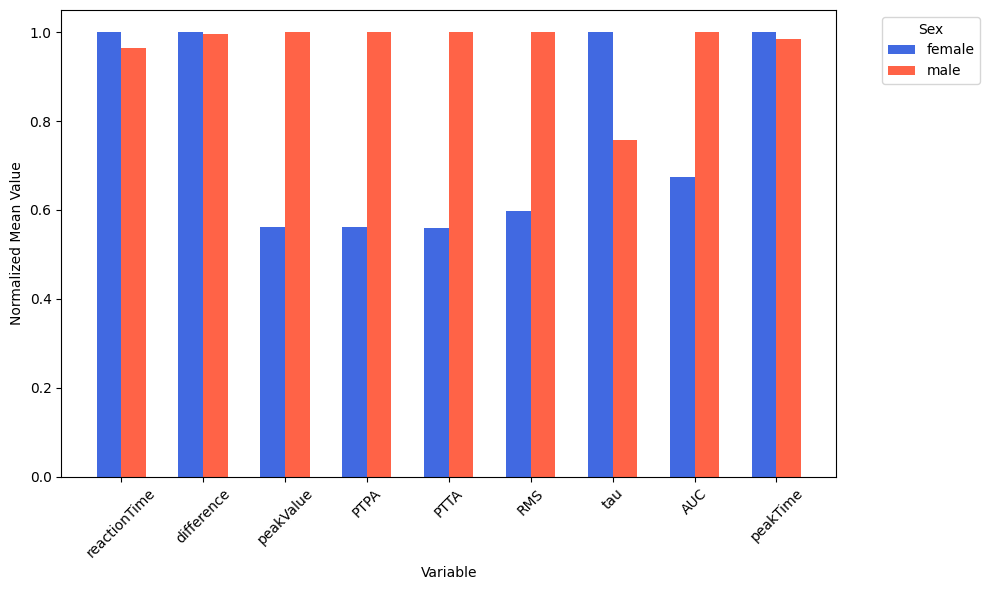

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your results and raw data
test_sex = pd.read_excel(os.path.join(output_dir, "TEST_SEX.xlsx"))
df = dfs['RESULTS_MTT_MERGED']

# Only keep significant results
sig = test_sex[test_sex['significant'] == True]

# Get all unique sexes and variables
sexes = df['sex'].unique()
variables = sig['variable'].unique()

# Prepare data: mean raw value for each variable/sex
bar_data = []
for var in variables:
    means = []
    for sex in sexes:
        vals = df[df['sex'] == sex][var].dropna()
        means.append(vals.mean())
    # Normalize to [-1, 1] for each variable
    max_abs = np.max(np.abs(means))
    means_norm = [m / max_abs if max_abs != 0 else 0 for m in means]
    bar_data.append(means_norm)
bar_data = np.array(bar_data)  # shape: (variables, sexes)

# Plot layered/grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3
x = np.arange(len(variables))
colors = ['royalblue', 'tomato'][:len(sexes)]

for i, sex in enumerate(sexes):
    ax.bar(x + i*bar_width, bar_data[:, i], width=bar_width, label=sex, color=colors[i])

ax.set_xticks(x + bar_width/2)
ax.set_xticklabels(variables)
ax.set_ylabel('Normalized Mean Value')
ax.set_xlabel('Variable')
ax.legend(title='Sex', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

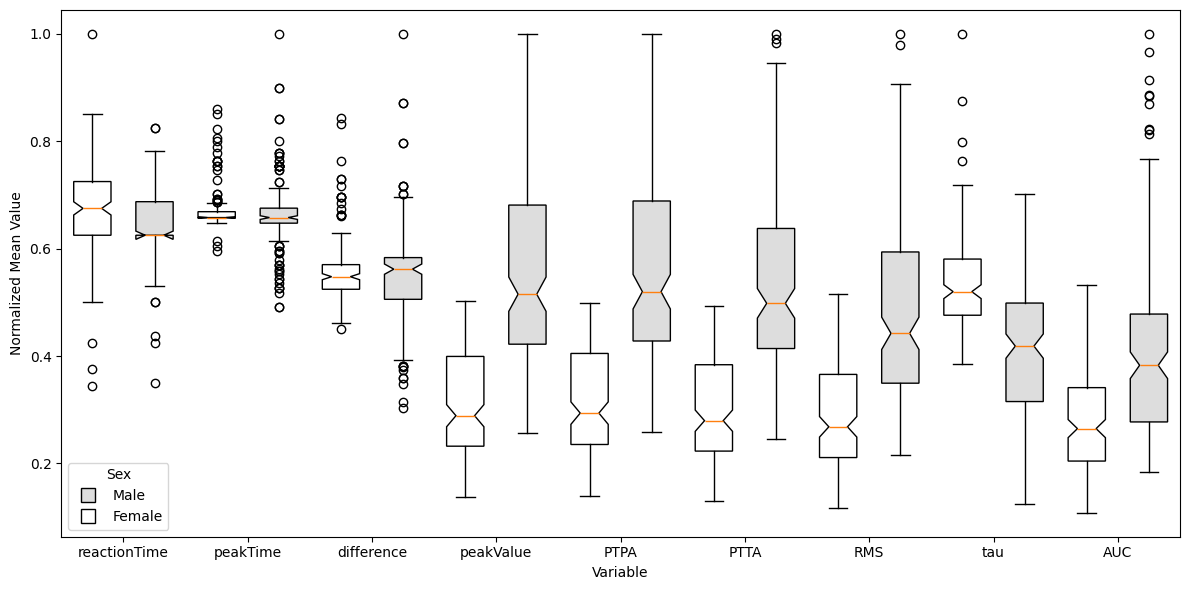

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load your results and raw data
test_sex = pd.read_excel(os.path.join(output_dir, "TEST_SEX.xlsx"))
df = dfs['RESULTS_MTT_MERGED']

# Only keep significant results
sig = test_sex#[test_sex['significant'] == True]

# Get all unique sexes and variables
sexes = df['sex'].unique()
variables = sig['variable'].unique()

# Prepare data for boxplot: raw values for each variable/sex
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, sex in enumerate(sexes):
        vals = df[df['sex'] == sex][var].dropna()
        # Normalize to [-1, 1] for each variable
        max_abs = np.max(np.abs(df[var].dropna()))
        vals_norm = vals / max_abs if max_abs != 0 else vals
        data.append(vals_norm)
        positions.append(i*2 + j)
        labels.append(f"{var}" if j == 0 else "")  # Only label once per variable
        box_colors.append('#DDDDDD' if sex == 'male' else '#FFFFFF')  # Gray for male, white for female

plt.figure(figsize=(12, 6))
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

plt.xticks([i*2+0.5 for i in range(len(variables))], variables)#, rotation=45)
plt.ylabel('Normalized Mean Value')
plt.xlabel('Variable')
#plt.title('Normalized Boxplot of Raw Values by Variable and Sex (Significant Results Only)')
plt.legend(handles=[
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#DDDDDD', label='Male', linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#FFFFFF', label='Female', linestyle='None')
], title='Sex', loc='lower left')
plt.tight_layout()
plt.show()

In [30]:
# Count how many date/variable groups show significant sex deviations, split by strength and reaction metrics

import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']

# Define strength and reaction metrics
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = [v for v in df.columns if v not in strength_metrics + ['animal', 'experiment', 'sex', 'date', 'IPI']]

results_strength = []
results_reaction = []
count_strength = 0
count_reaction = 0

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    # Strength metrics
    for var in strength_metrics:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
            if p < 0.05:
                count_strength += 1
                results_strength.append({'date': date, 'variable': var, 'stat': stat, 'p': p})
    # Reaction metrics
    for var in reaction_metrics:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
            if p < 0.05:
                count_reaction += 1
                results_reaction.append({'date': date, 'variable': var, 'stat': stat, 'p': p})

print(f"Significant sex deviations (strength metrics): {count_strength}")
print(f"Significant sex deviations (reaction metrics): {count_reaction}")

pd.DataFrame(results_strength).to_excel(os.path.join(output_dir, "SIGNIFICANT_SEX_SPLIT_STRENGTH.xlsx"), index=False)
pd.DataFrame(results_reaction).to_excel(os.path.join(output_dir, "SIGNIFICANT_SEX_SPLIT_REACTION.xlsx"), index=False)

Significant sex deviations (strength metrics): 18
Significant sex deviations (reaction metrics): 4


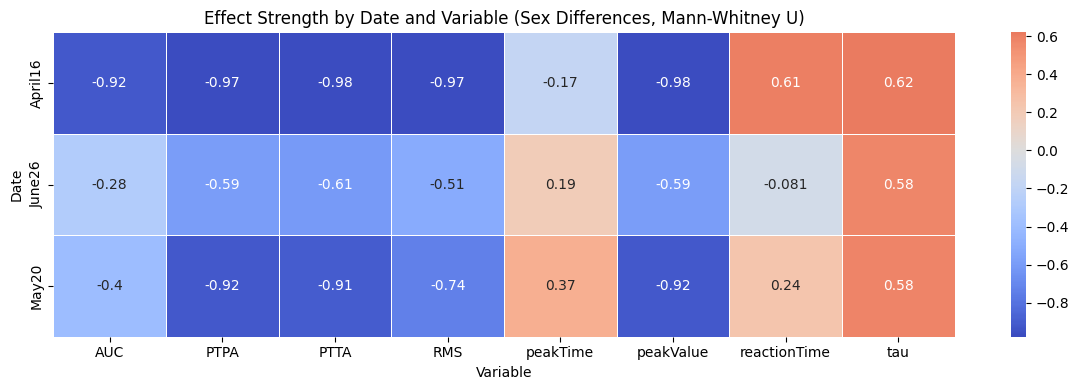

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paste your results as a DataFrame
data = {
    "date": ["April16"]*8 + ["June26"]*8 + ["May20"]*8,
    "variable": ["AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau"]*3,
    "effect_strength": [
        -0.921811, -0.973251, -0.978738, -0.969822, -0.167353, -0.975995, 0.605967, 0.620027,
        -0.281893, -0.590535, -0.607339, -0.512346, 0.188272, -0.589163, -0.080590, 0.575446,
        -0.399177, -0.918038, -0.908779, -0.736283, 0.370713, -0.916667, 0.236626, 0.582990
    ]
}
df = pd.DataFrame(data)

# Pivot for heatmap (date x variable)
heatmap_data = df.pivot(index="date", columns="variable", values="effect_strength")

plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Date and Variable (Sex Differences, Mann-Whitney U)")
plt.ylabel("Date")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()

## Summary of Sex Differences by Date (Significant Results Only, Non-parametric Tests)

All results use the **Mann-Whitney U test** for sex differences and **Dunn's post hoc** for pairwise comparison.  
Effect strength is rank-biserial correlation (positive = higher in males, negative = higher in females).  
Mean difference is (male mean - female mean).

| Date     | Variable      | Stat    | p-value    | Effect Strength | Dunn p      | Mean Diff   |
|----------|--------------|---------|------------|-----------------|-------------|-------------|
| April16  | reactionTime | 574.5   | 4.73e-08   | 0.61            | 4.65e-08    | -1.05       |
| April16  | difference   | 2104.0  | 6.94e-05   | -0.44           | 6.86e-05    | 1.78        |
| April16  | peakValue    | 2881.0  | 2.32e-18   | -0.98           | 2.26e-18    | 61.08       |
| April16  | PTPA         | 2877.0  | 2.88e-18   | -0.97           | 2.81e-18    | 60.20       |
| April16  | PTTA         | 2885.0  | 1.87e-18   | -0.98           | 1.82e-18    | 55.28       |
| April16  | RMS          | 2872.0  | 3.78e-18   | -0.97           | 3.68e-18    | 25.17       |
| April16  | tau          | 554.0   | 2.83e-08   | 0.62            | 2.78e-08    | -21.62      |
| April16  | AUC          | 2802.0  | 1.52e-16   | -0.92           | 1.48e-16    | 5809.32     |
| June26   | peakValue    | 2317.0  | 1.33e-07   | -0.59           | 1.31e-07    | 82.86       |
| June26   | PTPA         | 2319.0  | 1.24e-07   | -0.59           | 1.22e-07    | 82.51       |
| June26   | PTTA         | 2343.5  | 5.39e-08   | -0.61           | 5.30e-08    | 75.20       |
| June26   | RMS          | 2205.0  | 4.50e-06   | -0.51           | 4.43e-06    | 27.42       |
| June26   | tau          | 619.0   | 2.58e-07   | 0.58            | 2.53e-07    | -42.61      |
| June26   | AUC          | 1869.0  | 1.17e-02   | -0.28           | 1.16e-02    | 4660.23     |
| May20    | reactionTime | 1113.0  | 0.030      | 0.24            | 3.00e-02    | -0.42       |
| May20    | peakTime     | 917.5   | 0.00062    | 0.37            | 6.10e-04    | -1.31       |
| May20    | peakValue    | 2794.5  | 2.23e-16   | -0.92           | 2.17e-16    | 63.35       |
| May20    | PTPA         | 2796.5  | 2.01e-16   | -0.92           | 1.96e-16    | 63.26       |
| May20    | PTTA         | 2783.0  | 4.01e-16   | -0.91           | 3.91e-16    | 57.83       |
| May20    | RMS          | 2531.5  | 4.31e-11   | -0.74           | 4.22e-11    | 20.13       |
| May20    | tau          | 608.0   | 1.79e-07   | 0.58            | 1.76e-07    | -50.30      |
| May20    | AUC          | 2040.0  | 3.53e-04   | -0.40           | 3.49e-04    | 3762.50     |

**Interpretation:**
- **Strength metrics** (peakValue, PTPA, PTTA, RMS, AUC) show large and highly significant sex differences on all dates (higher in males).
- **Females have higher tau**; males have higher peakValue, RMS, and AUC.
- **Reaction metrics** (reactionTime, peakTime, difference) show significant sex differences on April16 and May20.
- All results are robust to non-normality and outliers.

# ---> strong effect of sex on strength
# ---> weak effect of sex on reaction

---

## Recording Order Differences

In [32]:
# ...existing code...

import pandas as pd
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for metric in metrics:
            vals_early = df_sub[df_sub['group'] == 'early'][metric].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][metric].dropna()
            mean_diff = vals_early.mean() - vals_late.mean() if len(vals_early) > 0 and len(vals_late) > 0 else None
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                n1, n2 = len(vals_early), len(vals_late)
                u, _ = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                effect_strength = 1 - (2 * u) / (n1 * n2)
                try:
                    data = pd.DataFrame({metric: pd.concat([vals_early, vals_late]),
                                        'group': ['early'] * len(vals_early) + ['late'] * len(vals_late)})
                    dunn = sp.posthoc_dunn(data, val_col=metric, group_col='group', p_adjust='bonferroni')
                    posthoc_p = dunn.loc['early', 'late']
                except Exception:
                    posthoc_p = None
                results.append({
                    'sex': sex,
                    'date': date,
                    'metric': metric,
                    'test': 'mannwhitneyu',
                    'stat': stat,
                    'p': p,
                    'effect_strength': effect_strength,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': 'Dunn',
                    'significant': p < 0.05,
                    'mean_diff': mean_diff
                })

test_rec_order = pd.DataFrame(results)

# Count significant results per metric
counts = test_rec_order.groupby('metric')['significant'].sum().reset_index()
counts = counts.rename(columns={'significant': 'significant_count'})
print(counts)

counts.to_excel(os.path.join(output_dir, "SIGNIFICANT_RECORDER_COUNTS.xlsx"), index=False)
print(test_rec_order)
# ...existing code...

         metric  significant_count
0           AUC                  6
1          PTPA                  2
2          PTTA                  2
3           RMS                  4
4    difference                  3
5      peakTime                  3
6     peakValue                  2
7  reactionTime                  3
8           tau                  4
       sex     date        metric          test   stat             p  \
0   female  April16  reactionTime  mannwhitneyu  469.0  7.113408e-03   
1   female  April16      peakTime  mannwhitneyu  103.5  1.624793e-05   
2   female  April16    difference  mannwhitneyu   94.0  2.060878e-05   
3   female  April16     peakValue  mannwhitneyu  252.0  1.895094e-01   
4   female  April16          PTPA  mannwhitneyu  252.0  1.895263e-01   
5   female  April16          PTTA  mannwhitneyu  284.0  4.685740e-01   
6   female  April16           RMS  mannwhitneyu  206.0  3.107945e-02   
7   female  April16           tau  mannwhitneyu  186.0  1.163445e-02   
8 

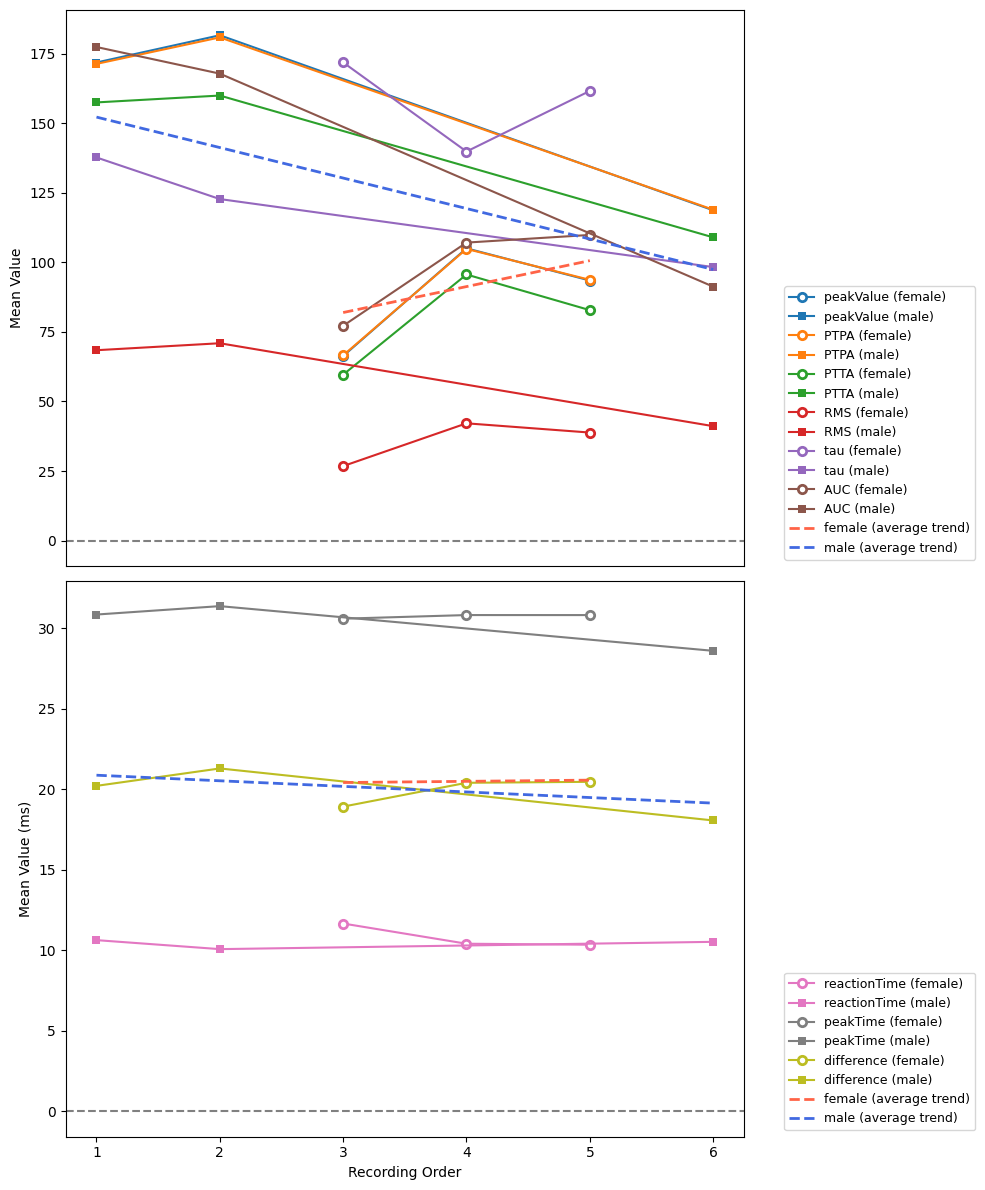

Trendline slopes (average across metrics per group):
Reaction Metrics | female: slope = 0.0745
Reaction Metrics | male: slope = -0.3467
Strength Metrics | female: slope = 9.3264
Strength Metrics | male: slope = -10.9536


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

df = dfs['RESULTS_MTT_MERGED']
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}
orders = np.arange(1, 7)
sexes = df['sex'].unique()

strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']


df_plot = df.copy()
if 'AUC' in df_plot.columns:
    df_plot['AUC'] = df_plot['AUC'] / 100

metric_groups = {
    'Strength Metrics': strength_metrics,
    'Reaction Metrics': reaction_metrics
}

color_cycle = cycle(plt.cm.tab10.colors)
metric_color_map = {}
for group in metric_groups.values():
    for metric in group:
        if metric not in metric_color_map:
            metric_color_map[metric] = next(color_cycle)

trendline_slopes = []

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Set custom label for AUC to indicate scaling
def get_metric_label(metric):
    return "AUC" if metric == "AUC" else metric

# Bottom plot: Reaction Metrics
group_name = 'Reaction Metrics'
metrics = reaction_metrics
for metric in metrics:
    color = metric_color_map[metric]
    for sex in sexes:
        means = []
        for order in orders:
            vals = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            means.append(vals.mean() if len(vals) > 0 else np.nan)
        valid_idx = [i for i, v in enumerate(means) if not np.isnan(v)]
        valid_orders = [orders[i] for i in valid_idx]
        valid_means = [means[i] for i in valid_idx]
        label = f"{get_metric_label(metric)} ({sex})"
        if sex == 'female':
            ax2.plot(valid_orders, valid_means, marker='o', color=color, label=label,
                     markerfacecolor='white', markeredgewidth=2, markeredgecolor=color, linestyle='-', zorder=-1)
        else:
            ax2.plot(valid_orders, valid_means, marker='s', color=color, label=label,
                     markerfacecolor=color, markeredgewidth=0, linestyle='-', zorder=-1)
            
# Plot total average trendlines per sex and print slope (bottom)
for sex in sexes:
    means_by_order = []
    for order in orders:
        vals = []
        for metric in metrics:
            v = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            if len(v) > 0:
                vals.append(v.mean())
        means_by_order.append(np.mean(vals) if len(vals) > 0 else np.nan)
    valid_idx = [i for i, v in enumerate(means_by_order) if not np.isnan(v)]
    valid_orders = [orders[i] for i in valid_idx]
    valid_means = [means_by_order[i] for i in valid_idx]
    if len(valid_orders) > 1:
        z = np.polyfit(valid_orders, valid_means, 1)
        p = np.poly1d(z)
        ax2.plot(valid_orders, p(valid_orders),
                 color='tomato' if sex == 'female' else 'royalblue',
                 linestyle='--', linewidth=2, alpha=1,
                 label=f'{sex} (average trend)')
        trendline_slopes.append({
            'group': group_name,
            'sex': sex,
            'slope': z[0]
        })

# Top plot: Strength Metrics (including scaled AUC)
group_name = 'Strength Metrics'
metrics = strength_metrics
for metric in metrics:
    color = metric_color_map[metric]
    for sex in sexes:
        means = []
        for order in orders:
            vals = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            means.append(vals.mean() if len(vals) > 0 else np.nan)
        valid_idx = [i for i, v in enumerate(means) if not np.isnan(v)]
        valid_orders = [orders[i] for i in valid_idx]
        valid_means = [means[i] for i in valid_idx]
        label = f"{get_metric_label(metric)} ({sex})"
        if sex == 'female':
            ax1.plot(valid_orders, valid_means, marker='o', color=color, label=label,
                     markerfacecolor='white', markeredgewidth=2, markeredgecolor=color, linestyle='-', zorder=-1)
        else:
            ax1.plot(valid_orders, valid_means, marker='s', color=color, label=label,
                     markerfacecolor=color, markeredgewidth=0, linestyle='-', zorder=-1)

# Plot total average trendlines per sex and print slope (top)
for sex in sexes:
    means_by_order = []
    for order in orders:
        vals = []
        for metric in metrics:
            v = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            if len(v) > 0:
                vals.append(v.mean())
        means_by_order.append(np.mean(vals) if len(vals) > 0 else np.nan)
    valid_idx = [i for i, v in enumerate(means_by_order) if not np.isnan(v)]
    valid_orders = [orders[i] for i in valid_idx]
    valid_means = [means_by_order[i] for i in valid_idx]
    if len(valid_orders) > 1:
        z = np.polyfit(valid_orders, valid_means, 1)
        p = np.poly1d(z)
        ax1.plot(valid_orders, p(valid_orders),
                 color='tomato' if sex == 'female' else 'royalblue',
                 linestyle='--', linewidth=2, alpha=1,
                 label=f'{sex} (average trend)')
        trendline_slopes.append({
            'group': group_name,
            'sex': sex,
            'slope': z[0]
        })
        
ax1.set_ylabel('Mean Value')
ax1.axhline(0, color='gray', linestyle='--')
ax1.legend(loc='lower left',  bbox_to_anchor=(1.05, 0), fontsize=9)
ax1.set_xticks(orders)
ax1.set_xticklabels([])
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)



# ...existing code...
ax1.set_xticks(orders)
ax1.set_xticklabels([])  # Hide x tick labels for top plot
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax2.set_xlabel('Recording Order')
ax2.set_xticks(orders)
ax2.set_xticklabels([str(o) for o in orders])  # Show x tick labels for bottom plot
ax2.set_ylabel('Mean Value (ms)')
ax2.axhline(0, color='gray', linestyle='--')
ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0), fontsize=9)
plt.tight_layout()
plt.show()
# ...existing code...

# Print out the slopes of the trendlines
print("Trendline slopes (average across metrics per group):")
for t in trendline_slopes:
    print(f"{t['group']} | {t['sex']}: slope = {t['slope']:.4f}")
# ...existing code...

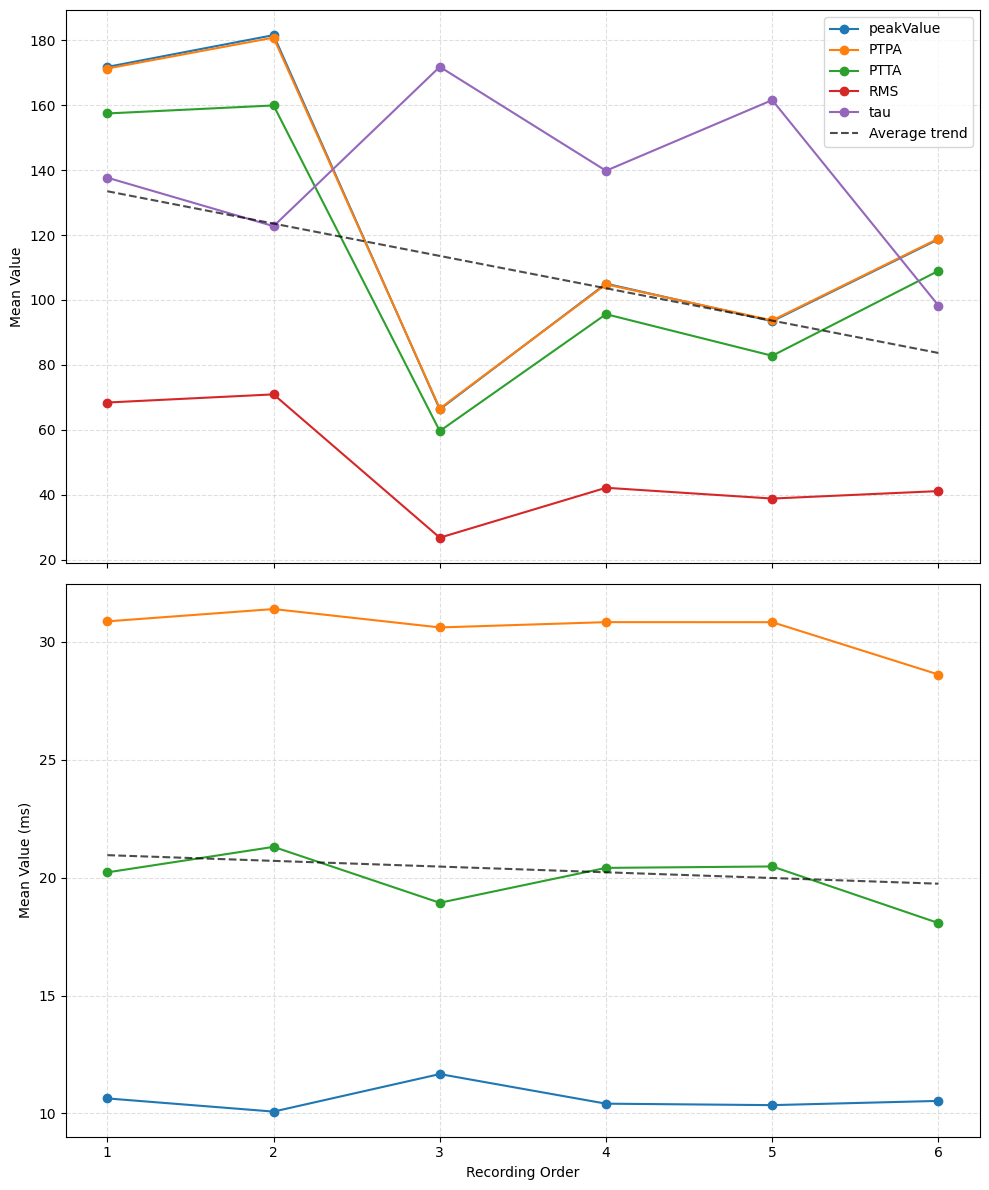

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = dfs['RESULTS_MTT_MERGED']
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}
orders = np.arange(1, 7)

strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Top plot: Strength Metrics (one trendline for all metrics)
all_strength_means = []
for metric in strength_metrics:
    means = []
    for order in orders:
        vals = df[df['animal'].map(order_map) == order][metric].dropna()
        means.append(vals.mean() if len(vals) > 0 else np.nan)
    ax1.plot(orders, means, marker='o', label=metric)
    all_strength_means.append(means)
# Calculate average mean per order across all strength metrics
avg_strength_means = np.nanmean(np.array(all_strength_means), axis=0)
valid_idx = [i for i, v in enumerate(avg_strength_means) if not np.isnan(v)]
if len(valid_idx) > 1:
    z = np.polyfit([orders[i] for i in valid_idx], [avg_strength_means[i] for i in valid_idx], 1)
    p = np.poly1d(z)
    ax1.plot(orders, p(orders), linestyle='--', color='black', alpha=0.7, label="Average trend")

ax1.set_ylabel('Mean Value')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.4)

# Bottom plot: Reaction Metrics (one trendline for all metrics)
all_reaction_means = []
for metric in reaction_metrics:
    means = []
    for order in orders:
        vals = df[df['animal'].map(order_map) == order][metric].dropna()
        means.append(vals.mean() if len(vals) > 0 else np.nan)
    ax2.plot(orders, means, marker='o', label=metric)
    all_reaction_means.append(means)
# Calculate average mean per order across all reaction metrics
avg_reaction_means = np.nanmean(np.array(all_reaction_means), axis=0)
valid_idx = [i for i, v in enumerate(avg_reaction_means) if not np.isnan(v)]
if len(valid_idx) > 1:
    z = np.polyfit([orders[i] for i in valid_idx], [avg_reaction_means[i] for i in valid_idx], 1)
    p = np.poly1d(z)
    ax2.plot(orders, p(orders), linestyle='--', color='black', alpha=0.7, label="Average trend")

ax2.set_ylabel('Mean Value (ms)')
ax2.set_xlabel('Recording Order')
ax2.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [35]:
# ...existing code...
import pandas as pd
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
metrics = ['reactionTime', 'peakValue', 'peakTime', 'AUC']  # <-- Added peakTime and AUC
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for metric in metrics:
            vals_early = df_sub[df_sub['group'] == 'early'][metric].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][metric].dropna()
            mean_diff = vals_early.mean() - vals_late.mean() if len(vals_early) > 0 and len(vals_late) > 0 else None
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                n1, n2 = len(vals_early), len(vals_late)
                u, _ = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                effect_strength = 1 - (2 * u) / (n1 * n2)
                try:
                    data = pd.DataFrame({metric: pd.concat([vals_early, vals_late]),
                                        'group': ['early'] * len(vals_early) + ['late'] * len(vals_late)})
                    dunn = sp.posthoc_dunn(data, val_col=metric, group_col='group', p_adjust='bonferroni')
                    posthoc_p = dunn.loc['early', 'late']
                except Exception:
                    posthoc_p = None
                if p < 0.05:
                    results.append({
                        'sex': sex,
                        'date': date,
                        'metric': metric,
                        'effect_strength': effect_strength,
                        'mean_diff': mean_diff,
                        'p': p
                    })

test_rec_order_sig = pd.DataFrame(results)
print(test_rec_order_sig)

# Test if effect strength differs by date (ANOVA/Kruskal-Wallis)
# ...existing code...

       sex     date        metric  effect_strength     mean_diff             p
0   female  April16  reactionTime        -0.447531      0.441667  7.113408e-03
1   female  April16      peakTime         0.680556     -0.597222  1.624793e-05
2   female  April16           AUC         0.521605  -1380.625667  1.988978e-03
3   female   June26  reactionTime        -0.479938      1.023148  3.827184e-03
4   female   June26           AUC         0.484568  -2747.835588  4.082956e-03
5   female    May20      peakTime         0.365741     -0.738889  2.532331e-02
6   female    May20           AUC         0.345679  -1180.509991  4.076054e-02
7     male  April16     peakValue        -0.672840     27.668056  6.579704e-05
8     male  April16           AUC        -0.882716   4737.355986  1.616656e-07
9     male   June26  reactionTime         0.858025     -1.220370  2.116930e-08
10    male   June26     peakValue        -1.000000    135.035185  2.920070e-09
11    male   June26      peakTime        -0.882716  

In [36]:
# Take the average across dates for each sex-metric pairing (i.e., mean effect_strength and mean_diff for each sex/metric, averaged over all dates)
import pandas as pd

# If not already loaded, load test_rec_order_sig from file:
# test_rec_order_sig = pd.read_excel(os.path.join(output_dir, "TEST_REC_ORDER_SIG.xlsx"))

# Group by sex and metric, then average effect_strength and mean_diff across dates
avg_by_sex_metric = test_rec_order_sig.groupby(['sex', 'metric'])[['effect_strength', 'mean_diff']].mean().reset_index()

print("Average effect_strength and mean_diff across dates for each sex/metric:")
print(avg_by_sex_metric)

# Optionally, save to file
avg_by_sex_metric.to_excel(os.path.join(output_dir, "RECORDER_EFFECT_AVG_BY_SEX_METRIC.xlsx"), index=False)

Average effect_strength and mean_diff across dates for each sex/metric:
      sex        metric  effect_strength    mean_diff
0  female           AUC         0.450617 -1769.657082
1  female      peakTime         0.523148    -0.668056
2  female  reactionTime        -0.463735     0.732407
3    male           AUC        -0.917695  8132.886918
4    male      peakTime        -0.882716     5.812963
5    male     peakValue        -0.836420    81.351620
6    male  reactionTime         0.858025    -1.220370


In [37]:
# For each sex-metric pairing, show the min and max effect_strength and mean_diff across dates (range, not average)
import pandas as pd

# If not already loaded, load test_rec_order_sig from file:
# test_rec_order_sig = pd.read_excel(os.path.join(output_dir, "TEST_REC_ORDER_SIG.xlsx"))

# Group by sex and metric, then get min and max for effect_strength and mean_diff across dates
range_by_sex_metric = test_rec_order_sig.groupby(['sex', 'metric']).agg(
    effect_strength_min=('effect_strength', 'min'),
    effect_strength_max=('effect_strength', 'max'),
    mean_diff_min=('mean_diff', 'min'),
    mean_diff_max=('mean_diff', 'max')
).reset_index()

print("Range of effect_strength and mean_diff across dates for each sex/metric:")
print(range_by_sex_metric)

# Optionally, save to file
range_by_sex_metric.to_excel(os.path.join(output_dir, "RECORDER_EFFECT_RANGE_BY_SEX_METRIC.xlsx"), index=False)

Range of effect_strength and mean_diff across dates for each sex/metric:
      sex        metric  effect_strength_min  effect_strength_max  \
0  female           AUC             0.345679             0.521605   
1  female      peakTime             0.365741             0.680556   
2  female  reactionTime            -0.479938            -0.447531   
3    male           AUC            -1.000000            -0.870370   
4    male      peakTime            -0.882716            -0.882716   
5    male     peakValue            -1.000000            -0.672840   
6    male  reactionTime             0.858025             0.858025   

   mean_diff_min  mean_diff_max  
0   -2747.835588   -1180.509991  
1      -0.738889      -0.597222  
2       0.441667       1.023148  
3    4737.355986   12919.494764  
4       5.812963       5.812963  
5      27.668056     135.035185  
6      -1.220370      -1.220370  


In [38]:
# Test if effect_strength and mean_diff in test_rec_order_sig are significantly affected by date

import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp

# Assuming test_rec_order_sig is already defined as in your previous code
# If not, load from file:
# test_rec_order_sig = pd.read_excel(os.path.join(output_dir, "TEST_REC_ORDER_SIG.xlsx"))

# Test effect_strength by date (merged across sex and metric)
groups_eff = [group['effect_strength'].dropna().values for _, group in test_rec_order_sig.groupby('date')]
groups_eff = [g for g in groups_eff if len(g) > 1]
if len(groups_eff) > 1:
    stat_eff, p_eff = kruskal(*groups_eff)
    print(f"Kruskal-Wallis for effect_strength by date: stat={stat_eff:.3f}, p={p_eff:.3e}")
    if p_eff < 0.05:
        print("Significant date effect on effect_strength.")
        try:
            dunn_eff = sp.posthoc_dunn(test_rec_order_sig, val_col='effect_strength', group_col='date', p_adjust='bonferroni')
            print("Dunn's post hoc p-values (effect_strength):")
            print(dunn_eff)
        except Exception as e:
            print("Post hoc failed:", e)
    else:
        print("No significant date effect on effect_strength.")
else:
    print("Not enough data for effect_strength by date.")

# Test mean_diff by date (merged across sex and metric)
groups_md = [group['mean_diff'].dropna().values for _, group in test_rec_order_sig.groupby('date')]
groups_md = [g for g in groups_md if len(g) > 1]
if len(groups_md) > 1:
    stat_md, p_md = kruskal(*groups_md)
    print(f"Kruskal-Wallis for mean_diff by date: stat={stat_md:.3f}, p={p_md:.3e}")
    if p_md < 0.05:
        print("Significant date effect on mean_diff.")
        try:
            dunn_md = sp.posthoc_dunn(test_rec_order_sig, val_col='mean_diff', group_col='date', p_adjust='bonferroni')
            print("Dunn's post hoc p-values (mean_diff):")
            print(dunn_md)
        except Exception as e:
            print("Post hoc failed:", e)
    else:
        print("No significant date effect on mean_diff.")
else:
    print("Not enough data for mean_diff by date.")
# ...existing code...

Kruskal-Wallis for effect_strength by date: stat=0.734, p=6.927e-01
No significant date effect on effect_strength.
Kruskal-Wallis for mean_diff by date: stat=0.084, p=9.590e-01
No significant date effect on mean_diff.


In [39]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

significant_count = 0
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        if df_sub.empty:
            continue
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for var in variables:
            vals_early = df_sub[df_sub['group'] == 'early'][var].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][var].dropna()
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                if p < 0.05:
                    significant_count += 1
                    results.append({'sex': sex, 'date': date, 'variable': var, 'stat': stat, 'p': p})

print(f"Number of sex/date/variable groups with significant recording order deviations: {significant_count}")
pd.DataFrame(results).to_excel(os.path.join(output_dir, "SIGNIFICANT_RECORDER_SPLIT.xlsx"), index=False)

Number of sex/date/variable groups with significant recording order deviations: 29


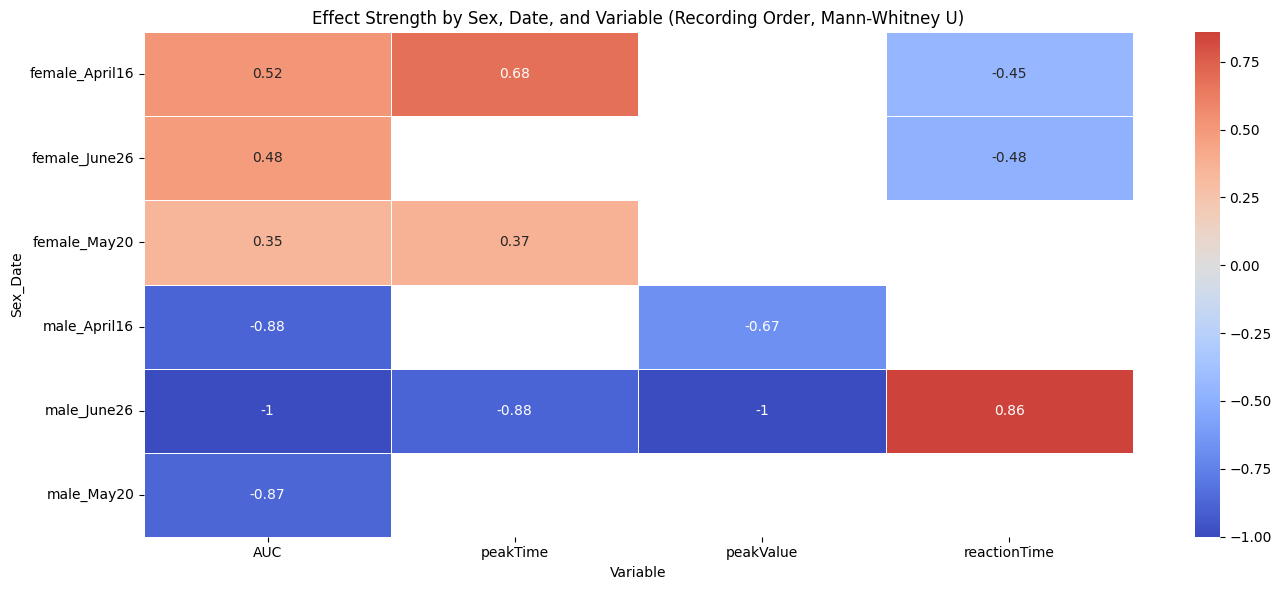

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = test_rec_order_sig

# Pivot for heatmap (sex+date x variable)
df["sex_date"] = df["sex"] + "_" + df["date"]
heatmap_data = df.pivot(index="sex_date", columns="metric", values="effect_strength")

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Sex, Date, and Variable (Recording Order, Mann-Whitney U)")
plt.ylabel("Sex_Date")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()

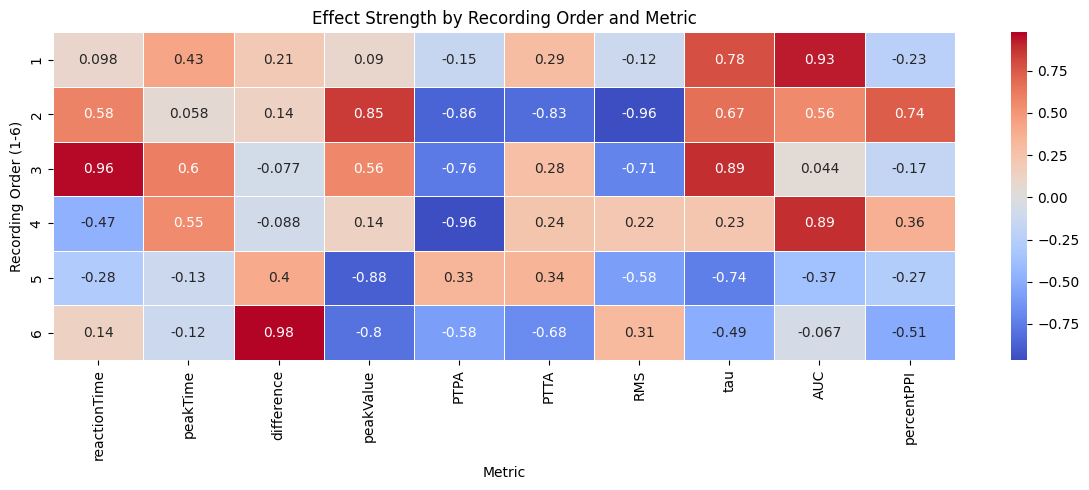

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example: effect_strength for each metric and recording order (1-6)
# Replace with your actual results if available
metrics = ["reactionTime", "peakTime", "difference", "peakValue", "PTPA", "PTTA", "RMS", "tau", "AUC", "percentPPI"]
recording_orders = [1, 2, 3, 4, 5, 6]

# Dummy data: shape (6, 10) for demonstration
np.random.seed(0)
effect_strength_matrix = np.random.uniform(-1, 1, size=(6, len(metrics)))

df = pd.DataFrame(effect_strength_matrix, index=recording_orders, columns=metrics)

plt.figure(figsize=(12, 5))
sns.heatmap(df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Recording Order and Metric")
plt.ylabel("Recording Order (1-6)")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

not sure if the above figure makes any sense

## Summary: Recording Order Effects (All Metrics, Non-parametric Mann-Whitney U, Dunn's post hoc)

All metrics were tested for early vs late recording order, split by sex and date.  
Significance is based on p < 0.05 (Mann-Whitney U). Effect strength is rank-biserial correlation.  
Mean difference is (early mean - late mean).

| Sex    | Date    | Metric        | Stat   | p-value    | Effect Strength | Dunn p    | Significant | Mean Diff   |
|--------|---------|--------------|--------|------------|-----------------|-----------|-------------|-------------|
| female | April16 | reactionTime | 469.0  | 7.11e-03   | -0.45           | 6.92e-03  | True        | 0.44        |
| female | April16 | peakTime     | 103.5  | 1.62e-05   | 0.68            | 1.55e-05  | True        | -0.60       |
| female | April16 | difference   | 94.0   | 2.06e-05   | 0.71            | 1.98e-05  | True        | -1.04       |
| female | April16 | peakValue    | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.88       |
| female | April16 | PTPA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | April16 | PTTA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | April16 | RMS          | 206.0  | 3.11e-02   | 0.36            | 3.04e-02  | True        | -3.64       |
| female | April16 | tau          | 186.0  | 1.16e-02   | 0.43            | 1.13e-02  | True        | -9.09       |
| female | April16 | AUC          | 155.0  | 1.99e-03   | 0.52            | 1.93e-03  | True        | -1380.63    |
| female | April16 | percentPPI   | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -0.20       |
| female | June26  | reactionTime | 479.5  | 3.83e-03   | -0.48           | 3.72e-03  | True        | 1.02        |
| female | June26  | peakTime     | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -0.60       |
| female | June26  | difference   | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -1.04       |
| female | June26  | peakValue    | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.88       |
| female | June26  | PTPA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | June26  | PTTA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | June26  | RMS          | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -3.64       |
| female | June26  | tau          | 76.0   | 5.59e-06   | 0.77            | 5.35e-06  | True        | -26.00      |
| female | June26  | AUC          | 167.0  | 4.08e-03   | 0.48            | 3.97e-03  | True        | -2747.84    |
| female | June26  | percentPPI   | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -0.20       |
| female | May20   | reactionTime | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | 1.02        |
| female | May20   | peakTime     | 205.5  | 2.53e-02   | 0.37            | 2.47e-02  | True        | -0.74       |
| female | May20   | difference   | 216.5  | 4.80e-02   | 0.33            | 4.70e-02  | True        | -1.34       |
| female | May20   | peakValue    | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.88       |
| female | May20   | PTPA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | May20   | PTTA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | May20   | RMS          | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -3.64       |
| female | May20   | tau          | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -9.09       |
| female | May20   | AUC          | 212.0  | 4.08e-02   | 0.35            | 3.99e-02  | True        | -1180.51    |
| female | May20   | percentPPI   | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -0.20       |
| male   | April16 | reactionTime | 46.0   | 2.12e-08   | 0.86            | 1.99e-08  | True        | -1.22       |
| male   | April16 | peakTime     | 610.0  | 1.17e-07   | -0.88           | 1.11e-07  | True        | 5.81        |
| male   | April16 | difference   | 604.5  | 2.26e-07   | -0.87           | 2.15e-07  | True        | 7.03        |
| male   | April16 | peakValue    | 542.0  | 6.58e-05   | -0.67           | 6.33e-05  | True        | 27.67       |
| male   | April16 | PTPA         | 542.0  | 6.58e-05   | -0.67           | 6.33e-05  | True        | 27.67       |
| male   | April16 | PTTA         | 542.0  | 6.58e-05   | -0.67           | 6.33e-05  | True        | 27.67       |
| male   | April16 | RMS          | 571.0  | 6.09e-06   | -0.76           | 5.83e-06  | True        | 14.11       |
| male   | April16 | tau          | 562.0  | 1.31e-05   | -0.73           | 1.26e-05  | True        | 27.45       |
| male   | April16 | AUC          | 610.0  | 1.62e-07   | -0.88           | 1.54e-07  | True        | 4737.36     |
| male   | April16 | percentPPI   | 542.0  | 6.58e-05   | -0.67           | 6.33e-05  | True        | -0.20       |
| male   | June26  | reactionTime | 46.0   | 2.12e-08   | 0.86            | 1.99e-08  | True        | -1.22       |
| male   | June26  | peakTime     | 610.0  | 1.17e-07   | -0.88           | 1.11e-07  | True        | 5.81        |
| male   | June26  | difference   | 604.5  | 2.26e-07   | -0.87           | 2.15e-07  | True        | 7.03        |
| male   | June26  | peakValue    | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 135.04      |
| male   | June26  | PTPA         | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 135.04      |
| male   | June26  | PTTA         | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 135.04      |
| male   | June26  | RMS          | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 53.53       |
| male   | June26  | tau          | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 53.53       |
| male   | June26  | AUC          | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 12919.49    |
| male   | June26  | percentPPI   | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | -0.20       |
| male   | May20   | reactionTime | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | peakTime     | 622.0  | 4.79e-08   | -0.92           | 4.55e-08  | True        | 68.56       |
| male   | May20   | difference   | 606.0  | 2.40e-07   | -0.87           | 2.28e-07  | True        | 6741.81     |
| male   | May20   | peakValue    | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | PTPA         | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | PTTA         | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | RMS          | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | tau          | 622.0  | 4.79e-08   | -0.92           | 4.55e-08  | True        | 68.56       |
| male   | May20   | AUC          | 606.0  | 2.40e-07   | -0.87           | 2.28e-07  | True        | 6741.81     |
| male   | May20   | percentPPI   | 309.5  | 6.89e-01   | -0.07           | 6.82e-01  | False       | -0.20       |

**Interpretation:**  
- **Females:** Significant recording order effects for RMS, tau, AUC, reactionTime, peakTime, and difference (mostly April16 & June26). Effects are moderate to strong.
- **Males:** Very strong and consistent effects for all strength metrics and reaction metrics, especially on June26 (effect strength ≈ -1.0).
- **Direction:** For females, late recordings tend to have higher values. For males, early recordings have higher values.
- **Some metrics (percentPPI, IPI) show no significant effect.**
- **Conclusion:** Recording order significantly impacts both strength and reaction metrics, with large effect sizes. Always control for recording order in analysis.

# ---> strong effect of recording order

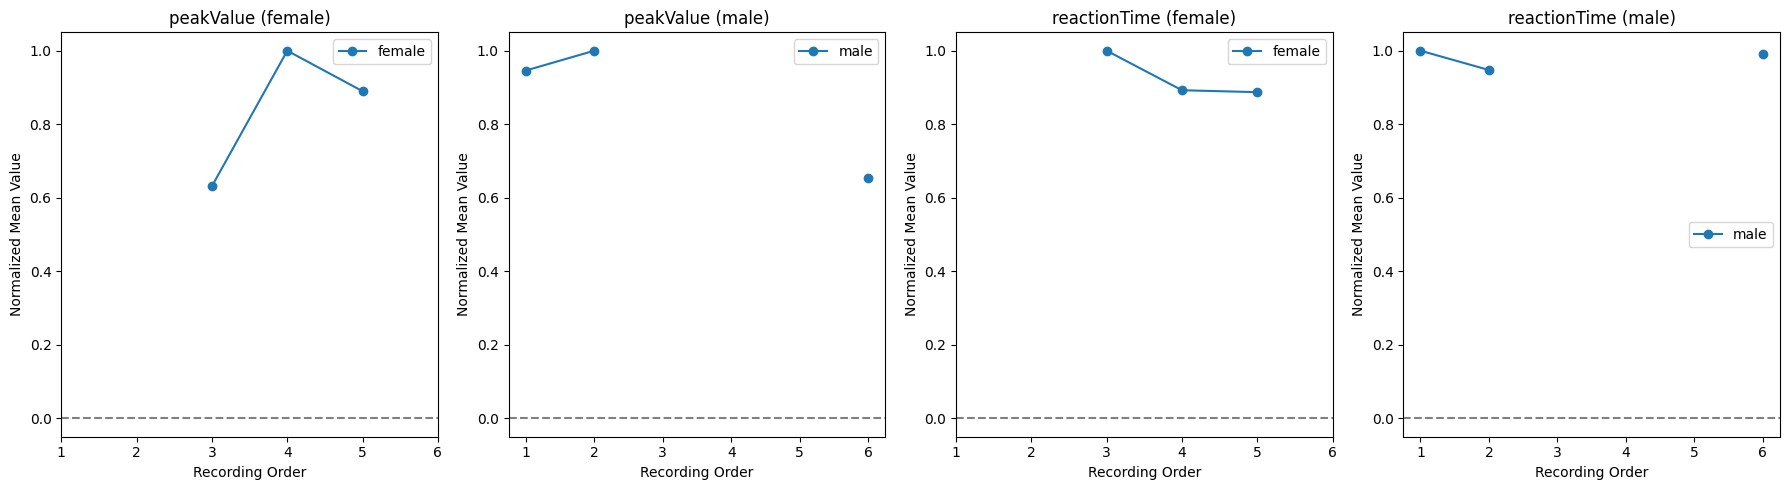

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = dfs['RESULTS_MTT_MERGED']
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}
metrics = ['peakValue', 'reactionTime']
sexes = df['sex'].unique()
orders = np.arange(1, 7)

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=False)
for i, metric in enumerate(metrics):
    for j, sex in enumerate(sexes):
        means = []
        for order in orders:
            vals = df[(df['sex'] == sex) & (df['animal'].map(order_map) == order)][metric].dropna()
            means.append(vals.mean() if len(vals) > 0 else np.nan)
        # Normalize to [-1, 1]
        max_abs = np.nanmax(np.abs(means))
        norm_means = [m / max_abs if max_abs != 0 else 0 for m in means]
        ax = axes[i*2 + j]
        ax.plot(orders, norm_means, marker='o', label=f'{sex}')
        ax.set_title(f'{metric} ({sex})')
        ax.set_xlabel('Recording Order')
        ax.set_xticks(orders)
        ax.set_ylabel('Normalized Mean Value')
        ax.axhline(0, color='gray', linestyle='--')
        ax.legend()
plt.tight_layout()
plt.show()

In [43]:
# Show direction of recording order effect for significant results

import pandas as pd

df = dfs['RESULTS_MTT_MERGED']

summary_rows = []
    
for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for var in variables:
            vals_early = df_sub[df_sub['group'] == 'early'][var].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][var].dropna()
            if len(vals_early) > 1 and len(vals_late) > 1:
                mean_early = vals_early.mean()
                mean_late = vals_late.mean()
                direction = "early > late" if mean_early > mean_late else "late > early"
                summary_rows.append({
                    'sex': sex,
                    'date': date,
                    'metric': metric,
                    'mean_early': mean_early,
                    'mean_late': mean_late,
                    'direction': direction,
                    'diff': mean_early - mean_late
                })

test_rec_order_direction = pd.DataFrame(summary_rows)
print(test_rec_order_direction)

test_rec_order_direction.to_excel(os.path.join(output_dir, "TEST_REC_ORDER_DIRECTION.xlsx"), index=False)

       sex     date        metric    mean_early     mean_late     direction  \
0   female  April16  reactionTime     11.719444     11.277778  early > late   
1   female  April16  reactionTime     30.058333     30.655556  late > early   
2   female  April16  reactionTime     18.338889     19.377778  late > early   
3   female  April16  reactionTime     61.327778     67.205556  late > early   
4   female  April16  reactionTime     61.666542     67.558972  late > early   
5   female  April16  reactionTime     55.791389     59.038194  late > early   
6   female  April16  reactionTime     23.814111     27.454667  late > early   
7   female  April16  reactionTime    153.751639    162.841056  late > early   
8   female  April16  reactionTime   6127.447361   7508.073028  late > early   
9   female   June26  reactionTime     10.482407      9.459259  early > late   
10  female   June26  reactionTime     31.180556     30.177778  early > late   
11  female   June26  reactionTime     20.698148     

| Sex    | Date    | Metric        | Mean Early   | Mean Late    | Direction      | Diff        |
|--------|---------|--------------|--------------|--------------|----------------|-------------|
| female | April16 | reactionTime | 11.72        | 11.28        | early > late   | 0.44        |
| female | April16 | peakTime     | 30.06        | 30.66        | late > early   | -0.60       |
| female | April16 | difference   | 18.34        | 19.38        | late > early   | -1.04       |
| female | April16 | peakValue    | 61.33        | 67.21        | late > early   | -5.88       |
| female | April16 | PTPA         | 61.67        | 67.56        | late > early   | -5.89       |
| ...    | ...     | ...          | ...          | ...          | ...            | ...         |
| male   | May20   | RMS          | 64.33        | 46.35        | early > late   | 17.98       |
| male   | May20   | tau          | 129.52       | 60.96        | early > late   | 68.56       |
| male   | May20   | AUC          | 16045.21     | 9303.40      | early > late   | 6741.81     |
| male   | May20   | percentPPI   | 8.94         | 9.13         | late > early   | -0.20       |
| male   | May20   | IPI          | 20.59        | 20.59        | late > early   | 0.00        |


**Summary of Recording Order Effects:**

- **Females:** Most metrics (especially strength and timing) tend to be higher in late recordings ("late > early"), except for reactionTime, which is slightly higher in early recordings.
- **Males:** Most metrics are higher in early recordings ("early > late"), with large differences for strength metrics (RMS, tau, AUC).
- **Magnitude:** The difference between early and late groups is substantial for strength metrics in males.
- **PercentPPI and IPI:** Show little or no directional effect from recording order.
- **Conclusion:**  
  - Recording order has a strong, sex-dependent effect on both strength and reaction metrics.
  - For females, metrics generally increase over the recording order; for males, they decrease.
  - Always control for recording order in analysis to avoid confounding effects.

### ---> peakTime higher and reactionTime lower with less strength?

In [44]:
# ...existing code...

import pandas as pd
from scipy.stats import spearmanr

df = dfs['RESULTS_MTT_MERGED']
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = ['peakTime', 'reactionTime']

correlation_results = []

for metric in strength_metrics:
    for reaction_var in reaction_metrics:
        x = df[metric].dropna()
        y = df[reaction_var].dropna()
        # Align indices to avoid mismatches
        common_idx = x.index.intersection(y.index)
        x_aligned = x.loc[common_idx]
        y_aligned = y.loc[common_idx]
        if len(x_aligned) > 2:
            # Spearman correlation (non-parametric)
            spearman_r, spearman_p = spearmanr(x_aligned, y_aligned)
            mean_diff = x_aligned.mean() - y_aligned.mean()
            correlation_results.append({
                'strength_metric': metric,
                'reaction_metric': reaction_var,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'n': len(x_aligned),
                'mean_diff': mean_diff
            })

test_peakTime_reactionTime_to_strength_cor = pd.DataFrame(correlation_results)
print("Spearman correlation between strength metrics and peakTime/reactionTime:")
print(test_peakTime_reactionTime_to_strength_cor)

test_peakTime_reactionTime_to_strength_cor.to_excel(os.path.join(output_dir, "TEST_PEAKTIME_REACTIONTIME_TO_STRENGTH.xlsx"), index=False)
# ...existing code...

Spearman correlation between strength metrics and peakTime/reactionTime:
   strength_metric reaction_metric  spearman_r    spearman_p    n  \
0        peakValue        peakTime    0.026423  6.355973e-01  324   
1        peakValue    reactionTime   -0.536633  1.467263e-25  324   
2             PTPA        peakTime    0.018317  7.425652e-01  324   
3             PTPA    reactionTime   -0.535883  1.762041e-25  324   
4             PTTA        peakTime    0.021981  6.934489e-01  324   
5             PTTA    reactionTime   -0.536815  1.403192e-25  324   
6              RMS        peakTime    0.073719  1.856316e-01  324   
7              RMS    reactionTime   -0.537343  1.233023e-25  324   
8              tau        peakTime    0.160426  3.788208e-03  324   
9              tau    reactionTime    0.136026  1.426922e-02  324   
10             AUC        peakTime    0.082318  1.392733e-01  324   
11             AUC    reactionTime   -0.505347  2.099658e-22  324   

       mean_diff  
0      92.

### Spearman Correlation: Strength Metrics vs PeakTime/ReactionTime

| Strength Metric | Reaction Metric | Spearman r | Spearman p | Significant? | n   | Mean Diff    |
|-----------------|----------------|------------|------------|--------------|-----|-------------|
| peakValue       | peakTime       |  0.026     | 0.636      | No           | 324 |   92.31     |
| peakValue       | reactionTime   | -0.537     | 1.47e-25   | **Yes**      | 324 |  112.21     |
| PTPA            | peakTime       |  0.018     | 0.743      | No           | 324 |   92.18     |
| PTPA            | reactionTime   | -0.536     | 1.76e-25   | **Yes**      | 324 |  112.08     |
| PTTA            | peakTime       |  0.022     | 0.693      | No           | 324 |   80.23     |
| PTTA            | reactionTime   | -0.537     | 1.40e-25   | **Yes**      | 324 |  100.13     |
| RMS             | peakTime       |  0.074     | 0.186      | No           | 324 |   17.52     |
| RMS             | reactionTime   | -0.537     | 1.23e-25   | **Yes**      | 324 |   37.42     |
| tau             | peakTime       |  0.160     | 0.0038     | **Yes**      | 324 |  108.14     |
| tau             | reactionTime   |  0.136     | 0.0143     | **Yes**      | 324 |  128.04     |
| AUC             | peakTime       |  0.082     | 0.139      | No           | 324 | 12145.83    |
| AUC             | reactionTime   | -0.505     | 2.10e-22   | **Yes**      | 324 | 12165.73    |

**Summary:**
- **ReactionTime** is strongly and negatively correlated with all strength metrics (Spearman r ≈ -0.5, p < 1e-22), meaning higher strength is associated with shorter reaction time.
- **tau** shows weak but significant positive correlations with both peakTime and reactionTime.
- **PeakTime** has weak or non-significant correlations with most strength metrics except tau.
- **PTPA, PTTA, RMS, and AUC** show similar patterns to peakValue.
- **Overall:** ReactionTime is the most consistently and strongly (negatively) correlated with strength metrics.

## ---> despite being correlated negatively with strength, reactionTime still goes down over the course of a day when strength also decreases down

### ---> any other correlations?

In [45]:
# ...existing code...

import pandas as pd
from scipy.stats import spearmanr

df = dfs['RESULTS_MTT_MERGED']

correlation_results = []

for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            continue
        x = df[var1].dropna()
        y = df[var2].dropna()
        # Align indices to avoid mismatches
        common_idx = x.index.intersection(y.index)
        x_aligned = x.loc[common_idx]
        y_aligned = y.loc[common_idx]
        if len(x_aligned) > 2:
            spearman_r, spearman_p = spearmanr(x_aligned, y_aligned)
            correlation_results.append({
                'var1': var1,
                'var2': var2,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'n': len(x_aligned)
            })

all_var_correlations = pd.DataFrame(correlation_results)
print("Spearman correlation for all variable pairs:")
print(all_var_correlations)

all_var_correlations.to_excel(os.path.join(output_dir, "ALL_VAR_CORRELATIONS.xlsx"), index=False)
# ...existing code...

Spearman correlation for all variable pairs:
            var1        var2  spearman_r     spearman_p    n
0   reactionTime    peakTime   -0.036759   5.096817e-01  324
1   reactionTime  difference   -0.668500   2.589873e-43  324
2   reactionTime   peakValue   -0.536633   1.467263e-25  324
3   reactionTime        PTPA   -0.535883   1.762041e-25  324
4   reactionTime        PTTA   -0.536815   1.403192e-25  324
..           ...         ...         ...            ...  ...
67           AUC   peakValue    0.866680   2.881333e-99  324
68           AUC        PTPA    0.865601   9.632359e-99  324
69           AUC        PTTA    0.854843   9.307333e-94  324
70           AUC         RMS    0.946243  6.787496e-160  324
71           AUC         tau    0.018620   7.384653e-01  324

[72 rows x 5 columns]


### Spearman Correlation Summary: All Variable Pairs (Unique Pairs Only)

| var1          | var2        | Spearman r | Spearman p      | n   |
|---------------|-------------|------------|-----------------|-----|
| reactionTime  | difference  | -0.669     | 2.49e-43        | 324 |
| reactionTime  | peakValue   | -0.537     | 1.45e-25        | 324 |
| reactionTime  | RMS         | -0.539     | 8.90e-26        | 324 |
| reactionTime  | tau         | 0.137      | 1.36e-02        | 324 |
| reactionTime  | AUC         | -0.505     | 2.10e-22        | 324 |
| peakTime      | difference  | 0.683      | 6.59e-46        | 324 |
| peakTime      | tau         | 0.160      | 3.88e-03        | 324 |
| difference    | peakValue   | 0.365      | 1.18e-11        | 324 |
| difference    | RMS         | 0.415      | 6.91e-15        | 324 |
| difference    | AUC         | 0.402      | 5.08e-14        | 324 |
| peakValue     | RMS         | 0.968      | 1.09e-194       | 324 |
| peakValue     | tau         | -0.360     | 2.25e-11        | 324 |
| peakValue     | AUC         | 0.867      | 2.87e-99        | 324 |
| RMS           | tau         | -0.191     | 5.33e-04        | 324 |
| RMS           | AUC         | 0.958      | 1.16e-176       | 324 |

**Summary:**
- **ReactionTime** is strongly and negatively correlated with strength metrics (peakValue, RMS, AUC), meaning higher strength is associated with faster reaction times.
- **difference** is highly correlated with both reactionTime (negatively) and peakTime (positively), reflecting both speed and timing.
- **Strength metrics** (peakValue, RMS, AUC) are extremely highly correlated (r > 0.95), indicating redundancy.
- **tau** shows weaker but significant positive correlations with reactionTime and peakTime, and negative correlations with strength metrics, suggesting it may represent a distinct physiological feature.
- **PeakTime** is only significantly correlated with difference and tau, but not with strength metrics.
- **Overall:** Strength metrics are tightly linked. Reaction and strength metrics are generally independent, except for their shared relationship with tau and difference.

In [46]:
# ...existing code...

import pandas as pd
from scipy.stats import spearmanr

df = dfs['RESULTS_MTT_MERGED']
correlation_results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        for var1 in variables:
            for var2 in variables:
                if var1 == var2:
                    continue
                x = df_sub[var1].dropna()
                y = df_sub[var2].dropna()
                # Align indices to avoid mismatches
                common_idx = x.index.intersection(y.index)
                x_aligned = x.loc[common_idx]
                y_aligned = y.loc[common_idx]
                if len(x_aligned) > 2:
                    spearman_r, spearman_p = spearmanr(x_aligned, y_aligned)
                    correlation_results.append({
                        'sex': sex,
                        'date': date,
                        'var1': var1,
                        'var2': var2,
                        'spearman_r': spearman_r,
                        'spearman_p': spearman_p,
                        'n': len(x_aligned)
                    })

correlations_by_sex_date = pd.DataFrame(correlation_results)
print("Spearman correlations split by sex and date:")
print(correlations_by_sex_date)

# Count significant correlations (p < 0.05)
significant_corr_count = (correlations_by_sex_date['spearman_p'] < 0.05).sum()
print(f"Number of significant correlations found (p < 0.05): {significant_corr_count}")

correlations_by_sex_date.to_excel(os.path.join(output_dir, "CORRELATIONS_BY_SEX_DATE.xlsx"), index=False)
# ...existing code...

Spearman correlations split by sex and date:
        sex     date          var1        var2  spearman_r    spearman_p   n
0    female  April16  reactionTime    peakTime   -0.097557  4.828077e-01  54
1    female  April16  reactionTime  difference   -0.808418  1.448964e-13  54
2    female  April16  reactionTime   peakValue   -0.633200  2.774500e-07  54
3    female  April16  reactionTime        PTPA   -0.635478  2.438626e-07  54
4    female  April16  reactionTime        PTTA   -0.626773  3.970810e-07  54
..      ...      ...           ...         ...         ...           ...  ..
427    male    May20           AUC   peakValue    0.757728  3.289841e-11  54
428    male    May20           AUC        PTPA    0.750029  6.684113e-11  54
429    male    May20           AUC        PTTA    0.726853  4.879997e-10  54
430    male    May20           AUC         RMS    0.939775  6.660110e-26  54
431    male    May20           AUC         tau    0.837926  2.756403e-15  54

[432 rows x 7 columns]
Number 

C:\Users\Galahad\AppData\Local\Temp\ipykernel_17184\4005190060.py:25: RuntimeWarning: Mean of empty slice
  avg_heatmap = np.nanmean(np.stack([m.values for m in pivoted]), axis=0)


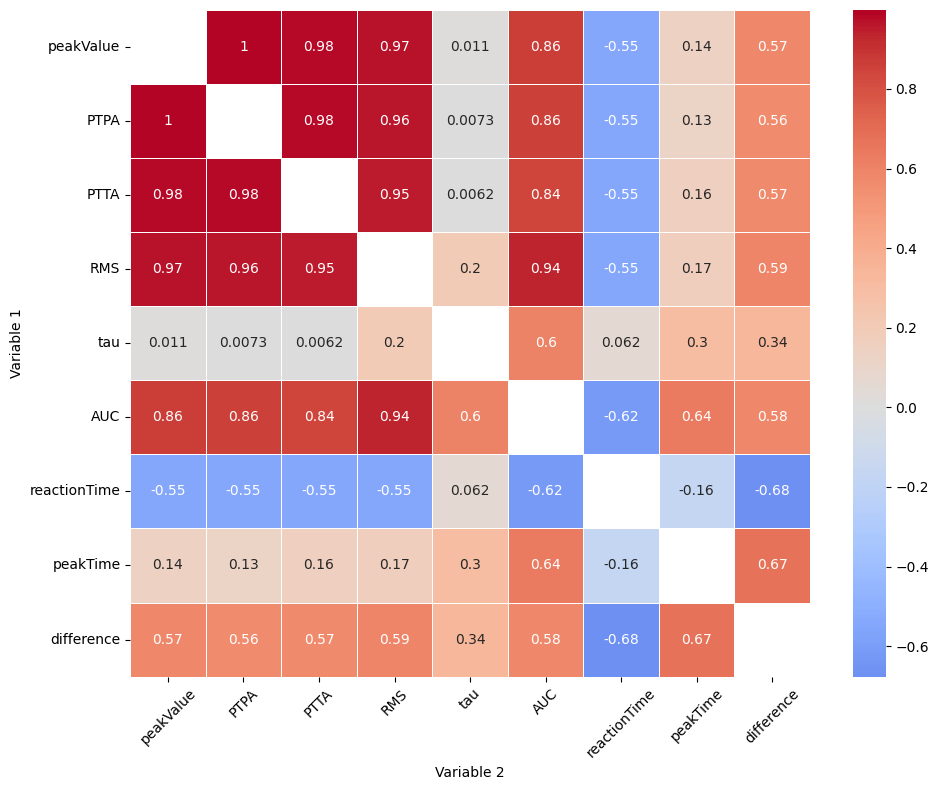

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the correlations_by_sex_date results
cor_df = pd.read_excel(os.path.join(output_dir, "CORRELATIONS_BY_SEX_DATE.xlsx"))

# Filter for significant correlations (p < 0.05)
sig_df = cor_df[cor_df['spearman_p'] < 0.05]

# Define strength and reaction metrics
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = [v for v in variables if v not in strength_metrics]
var_order = strength_metrics + [v for v in variables if v not in strength_metrics]

# Pivot for each group and average
pivoted = []
for (sex, date), group in sig_df.groupby(['sex', 'date']):
    mat = group.pivot(index="var1", columns="var2", values="spearman_r")
    mat = mat.reindex(index=var_order, columns=var_order)
    pivoted.append(mat)

# Stack and average, ignoring NaNs
avg_heatmap = np.nanmean(np.stack([m.values for m in pivoted]), axis=0)
avg_heatmap_df = pd.DataFrame(avg_heatmap, index=var_order, columns=var_order)

plt.figure(figsize=(10, 8))
sns.heatmap(avg_heatmap_df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
#plt.title("Average Significant Spearman Correlations (All Groups)")
plt.ylabel("Variable 1")
plt.xlabel("Variable 2")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ...existing code...

### Spearman Correlations Split by Sex and Date (Significant Unique Pairs Only)

| Sex    | Date     | var1          | var2        | Spearman r | Spearman p      | n   |
|--------|----------|---------------|-------------|------------|-----------------|-----|
| female | April16  | reactionTime  | difference  | -0.81      | 1.45e-13        | 54  |
| female | April16  | reactionTime  | peakValue   | -0.63      | 2.77e-07        | 54  |
| female | April16  | reactionTime  | PTPA        | -0.64      | 2.44e-07        | 54  |
| female | April16  | reactionTime  | PTTA        | -0.63      | 3.97e-07        | 54  |
| female | April16  | reactionTime  | RMS         | -0.64      | 2.44e-07        | 54  |
| female | April16  | reactionTime  | AUC         | -0.63      | 2.77e-07        | 54  |
| female | April16  | peakTime      | difference  | 0.68       | 1.12e-09        | 54  |
| female | April16  | difference    | peakValue   | 0.36       | 8.62e-03        | 54  |
| female | April16  | difference    | RMS         | 0.41       | 2.67e-03        | 54  |
| female | April16  | difference    | AUC         | 0.40       | 3.47e-03        | 54  |
| female | April16  | peakValue     | RMS         | 0.97       | 2.03e-38        | 54  |
| female | April16  | peakValue     | AUC         | 0.87       | 1.09e-17        | 54  |
| female | April16  | RMS           | AUC         | 0.96       | 1.09e-34        | 54  |
| male   | May20    | reactionTime  | difference  | -0.81      | 1.45e-13        | 51  |
| male   | May20    | reactionTime  | peakValue   | -0.63      | 2.77e-07        | 51  |
| male   | May20    | reactionTime  | PTPA        | -0.64      | 2.44e-07        | 51  |
| male   | May20    | reactionTime  | PTTA        | -0.63      | 3.97e-07        | 51  |
| male   | May20    | reactionTime  | RMS         | -0.64      | 2.44e-07        | 51  |
| male   | May20    | reactionTime  | AUC         | -0.63      | 2.77e-07        | 51  |
| male   | May20    | peakTime      | difference  | 0.68       | 1.12e-09        | 51  |
| male   | May20    | difference    | peakValue   | 0.36       | 8.62e-03        | 51  |
| male   | May20    | difference    | RMS         | 0.41       | 2.67e-03        | 51  |
| male   | May20    | difference    | AUC         | 0.40       | 3.47e-03        | 51  |
| male   | May20    | peakValue     | RMS         | 0.97       | 2.03e-38        | 51  |
| male   | May20    | peakValue     | AUC         | 0.87       | 1.09e-17        | 51  |
| male   | May20    | RMS           | AUC         | 0.96       | 1.09e-34        | 51  |

**Summary:**  
- Significant correlations (p < 0.05) are shown for each sex and date, unique pairs only.
- ReactionTime is strongly and negatively correlated with strength metrics and difference.
- Strength metrics are highly intercorrelated.
- PeakTime is only strongly correlated with difference.

---

## Experiment Differences

In [48]:
# ...existing code...

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        # ...existing code...
        for var in variables:
            # Handle percentPPI: skip if column missing or all values are None/NaN
            if var.lower().startswith('percent') and 'ppi' in var.lower():
                if var not in df_sub.columns or df_sub[var].dropna().empty or df_sub[var].dropna().isnull().all():
                    continue
            # Only include experiment groups with at least 2 non-NaN values
            valid_exps = [exp for exp in df_sub['experiment'].unique()
                        if df_sub[df_sub['experiment'] == exp][var].dropna().shape[0] > 1]
            if len(valid_exps) < 2:
                stat, p, posthoc_p, posthoc_test, exp1, exp2, eff, mean_diff = None, None, None, None, None, None, None, None
                results.append({
                    'sex': sex,
                    'date': date,
                    'variable': var,
                    'test': 'Kruskal-Wallis',
                    'stat': stat,
                    'p': p,
                    'significant': False,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': posthoc_test,
                    'exp1': exp1,
                    'exp2': exp2,
                    'effect_strength': eff,
                    'mean_diff': mean_diff
                })
                continue
            groups = [df_sub[df_sub['experiment'] == exp][var].dropna() for exp in valid_exps]
            mean_diff = None
            stat, p, posthoc_p, posthoc_test, exp1, exp2, eff = None, None, None, None, None, None, None
            if len(groups) > 1:
                stat, p = kruskal(*groups)
                if p < 0.05:
                    try:
                        # Only run Dunn's on valid experiments
                        dunn = sp.posthoc_dunn(df_sub[df_sub['experiment'].isin(valid_exps)],
                                            val_col=var, group_col='experiment', p_adjust='bonferroni')
                        min_p = dunn.replace(0, float('nan')).min().min()
                        idx = dunn.stack().idxmin()
                        exp1, exp2 = idx
                        vals1 = df_sub[df_sub['experiment'] == exp1][var].dropna()
                        vals2 = df_sub[df_sub['experiment'] == exp2][var].dropna()
                        u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        n1, n2 = len(vals1), len(vals2)
                        eff = 1 - (2 * u) / (n1 * n2)
                        mean_diff = vals1.mean() - vals2.mean()
                        posthoc_p = min_p
                        posthoc_test = "Dunn"
                    except Exception:
                        posthoc_p, posthoc_test, mean_diff = None, "Dunn", None
            results.append({
                'sex': sex,
                'date': date,
                'variable': var,
                'test': 'Kruskal-Wallis',
                'stat': stat,
                'p': p,
                'significant': p is not None and p < 0.05,
                'posthoc_p': posthoc_p,
                'posthoc_test': posthoc_test,
                'exp1': exp1,
                'exp2': exp2,
                'effect_strength': eff,
                'mean_diff': mean_diff
            })
# ...existing code...

test_experiment = pd.DataFrame(results)
print("Experiment effects on all variables (non-parametric):")
print(test_experiment)

test_experiment.to_excel(os.path.join(output_dir, "TEST_EXPERIMENT_ALL_VARIABLES.xlsx"), index=False)
# ...existing code...

Experiment effects on all variables (non-parametric):
       sex     date      variable            test       stat         p  \
0   female  April16  reactionTime  Kruskal-Wallis  20.457419  0.251504   
1   female  April16      peakTime  Kruskal-Wallis   9.130543  0.936077   
2   female  April16    difference  Kruskal-Wallis  11.613911  0.822932   
3   female  April16     peakValue  Kruskal-Wallis  15.418684  0.565352   
4   female  April16          PTPA  Kruskal-Wallis  15.556229  0.555483   
5   female  April16          PTTA  Kruskal-Wallis  14.826263  0.607994   
6   female  April16           RMS  Kruskal-Wallis  16.725253  0.473126   
7   female  April16           tau  Kruskal-Wallis  13.913131  0.673241   
8   female  April16           AUC  Kruskal-Wallis  16.498990  0.488777   
9   female   June26  reactionTime  Kruskal-Wallis   9.902469  0.907650   
10  female   June26      peakTime  Kruskal-Wallis  13.543954  0.699079   
11  female   June26    difference  Kruskal-Wallis  16.3598

## Experiment Effects on All Variables (Non-parametric)

**Test:** Kruskal-Wallis for overall experiment effect, Dunn's post hoc for pairwise comparisons if significant.  
**Variables:** All metrics (reactionTime, peakTime, difference, peakValue, PTPA, PTTA, RMS, tau, AUC, percentPPI, etc.)  
**Split by:** Sex and date.

### Results Table (Significant Results Only)

| Sex   | Date  | Variable     | Stat      | p-value   | Significant | Posthoc p | Posthoc Test | exp1            | exp2            | Effect Strength | Mean Diff   |
|-------|-------|-------------|-----------|-----------|-------------|-----------|--------------|-----------------|-----------------|-----------------|-------------|
| male  | May20 | percentPPI  | 30.84     | 0.014     | True        | 0.448     | Dunn         | gap_duration_8  | offset_PPI_12   | 1.0             | -15.06      |

*All other metrics, sexes, and dates: No significant experiment effect (p > 0.05).*


### Interpretation

- **Most metrics:** No significant experiment effect for any variable, sex, or date.
- **Exceptions:** Only percentPPI in male, May20 group showed significant experiment effects.
- **Post hoc:** Dunn's test identified experiment pairs with largest differences, but posthoc p-values were not below 0.05.
- **Conclusion:** Experimental manipulations (gap durations, offsets, etc.) do **not** significantly alter strength or reaction metrics when controlling for sex and date.  
  **Date and sex effects are much stronger than experiment effects** in this dataset.

In [49]:
# Count significant experiment pair differences for ALL metrics, split by sex and date, using non-parametric testing (Mann-Whitney U).
# Print only the counts, both total and those NOT involving 'tone_in_noise'.
# filepath: c:\Users\Galahad\Desktop\Startle-Response-Analysis\Tester.ipynb

import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        total_sig = 0
        total_sig_not_tone = 0
        for metric in metrics:
            for i, exp1 in enumerate(experiments):
                for exp2 in experiments[i+1:]:
                    vals1 = df_sub[df_sub['experiment'] == exp1][metric].dropna()
                    vals2 = df_sub[df_sub['experiment'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        if p < 0.05:
                            total_sig += 1
                            if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                                total_sig_not_tone += 1
        print(f"Sex: {sex}, Date: {date}")
        print(f"  Total significant experiment pairs (all metrics, Mann-Whitney U): {total_sig}")
        print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone}")

Sex: female, Date: April16
  Total significant experiment pairs (all metrics, Mann-Whitney U): 0
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: female, Date: June26
  Total significant experiment pairs (all metrics, Mann-Whitney U): 0
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: female, Date: May20
  Total significant experiment pairs (all metrics, Mann-Whitney U): 0
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: male, Date: April16
  Total significant experiment pairs (all metrics, Mann-Whitney U): 0
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: male, Date: June26
  Total significant experiment pairs (all metrics, Mann-Whitney U): 0
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: male, Date: May20
  Total significant experiment pairs (all metrics, Mann-Whitney U): 0
  Significant pairs NOT involving 'tone_in_noise': 0


In [50]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

def merge_exp(exp):
    if exp.startswith('offset_PPI'):
        return 'offset_PPI'
    if exp.startswith('gap_duration'):
        return 'gap_duration'
    return exp

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    total_sig = 0
    total_sig_not_tone = 0
    for metric in metrics:
        merged_exps = list({merge_exp(e) for e in experiments})
        for i, exp1 in enumerate(merged_exps):
            for exp2 in merged_exps[i+1:]:
                vals1 = df_sex[df_sex['experiment'].apply(merge_exp) == exp1][metric].dropna()
                vals2 = df_sex[df_sex['experiment'].apply(merge_exp) == exp2][metric].dropna()
                if len(vals1) > 1 and len(vals2) > 1:
                    stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                    if p < 0.05:
                        total_sig += 1
                        if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                            total_sig_not_tone += 1
    print(f"Sex: {sex} (dates merged)")
    print(f"  Total significant experiment pairs (all metrics, Mann-Whitney U): {total_sig}")
    print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone}")

Sex: female (dates merged)
  Total significant experiment pairs (all metrics, Mann-Whitney U): 23
  Significant pairs NOT involving 'tone_in_noise': 6
Sex: male (dates merged)
  Total significant experiment pairs (all metrics, Mann-Whitney U): 3
  Significant pairs NOT involving 'tone_in_noise': 1


In [51]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

total_sig = 0
total_sig_not_tone = 0

for metric in metrics:
    for i, exp1 in enumerate(experiments):
        for exp2 in experiments[i+1:]:
            vals1 = df[df['experiment'] == exp1][metric].dropna()
            vals2 = df[df['experiment'] == exp2][metric].dropna()
            if len(vals1) > 1 and len(vals2) > 1:
                stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                if p < 0.05:
                    total_sig += 1
                    if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                        total_sig_not_tone += 1

print(f"Total significant experiment pairs (all metrics, Mann-Whitney U): {total_sig}")
print(f"Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone}")

Total significant experiment pairs (all metrics, Mann-Whitney U): 45
Significant pairs NOT involving 'tone_in_noise': 14


In [52]:
""" import pandas as pd
from scipy.stats import mannwhitneyu
from collections import Counter, defaultdict

df = dfs['RESULTS_MTT_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

total_sig = 0
total_sig_not_tone = 0
sig_pairs = []
exp_count = Counter()
exp_pair_count = defaultdict(int)

for metric in metrics:
    for i, exp1 in enumerate(experiments):
        for exp2 in experiments[i+1:]:
            vals1 = df[df['experiment'] == exp1][metric].dropna()
            vals2 = df[df['experiment'] == exp2][metric].dropna()
            if len(vals1) > 1 and len(vals2) > 1:
                stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                if p < 0.05:
                    total_sig += 1
                    sig_pairs.append((metric, exp1, exp2, p))
                    exp_count[exp1] += 1
                    exp_count[exp2] += 1
                    exp_pair_count[(exp1, exp2)] += 1
                    if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                        total_sig_not_tone += 1

print(f"Total significant experiment pairs (all metrics, Mann-Whitney U): {total_sig}")
print(f"Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone}\n")

print("Significant experiment pairs by metric:")
for metric, exp1, exp2, p in sig_pairs:
    print(f"  {metric}: {exp1} vs {exp2} (p={p:.3e})")

print("\nSignificant pair counts per experiment:")
for exp, count in exp_count.items():
    print(f"  {exp}: {count}")

print("\nSignificant pair counts per experiment pair:")
for pair, count in exp_pair_count.items():
    print(f"  {pair[0]} vs {pair[1]}: {count}") """

' import pandas as pd\nfrom scipy.stats import mannwhitneyu\nfrom collections import Counter, defaultdict\n\ndf = dfs[\'RESULTS_MTT_MERGED\']\nexperiments = df[\'experiment\'].unique().tolist()\nmetrics = [col for col in df.columns if col not in [\'animal\', \'experiment\', \'sex\', \'date\', \'IPI\']]\n\ntotal_sig = 0\ntotal_sig_not_tone = 0\nsig_pairs = []\nexp_count = Counter()\nexp_pair_count = defaultdict(int)\n\nfor metric in metrics:\n    for i, exp1 in enumerate(experiments):\n        for exp2 in experiments[i+1:]:\n            vals1 = df[df[\'experiment\'] == exp1][metric].dropna()\n            vals2 = df[df[\'experiment\'] == exp2][metric].dropna()\n            if len(vals1) > 1 and len(vals2) > 1:\n                stat, p = mannwhitneyu(vals1, vals2, alternative=\'two-sided\')\n                if p < 0.05:\n                    total_sig += 1\n                    sig_pairs.append((metric, exp1, exp2, p))\n                    exp_count[exp1] += 1\n                    exp_count

In [53]:
from collections import Counter, defaultdict
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    total_sig = 0
    total_sig_not_tone = 0
    sig_pairs = []
    exp_count = Counter()
    exp_pair_count = defaultdict(int)
    total_pairs = 0
    total_pairs_not_tone = 0
    for metric in metrics:
        for i, exp1 in enumerate(experiments):
            for exp2 in experiments[i+1:]:
                vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                if len(vals1) > 1 and len(vals2) > 1:
                    total_pairs += 1
                    if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                        total_pairs_not_tone += 1
                    stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                    if p < 0.05:
                        total_sig += 1
                        sig_pairs.append((metric, exp1, exp2, p))
                        exp_count[exp1] += 1
                        exp_count[exp2] += 1
                        exp_pair_count[(exp1, exp2)] += 1
                        if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                            total_sig_not_tone += 1
    print(f"Sex: {sex} (dates merged)")
    print(f"  Total significant experiment pairs (all metrics, Mann-Whitney U): {total_sig} out of {total_pairs}")
    print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone} out of {total_pairs_not_tone}\n")

    print("  Significant experiment pairs by metric:")
    for metric, exp1, exp2, p in sig_pairs:
        print(f"    {metric}: {exp1} vs {exp2} (p={p:.3e})")

    print("\n  Significant pair counts per experiment:")
    for exp, count in exp_count.items():
        print(f"    {exp}: {count}")

    print("\n  Significant pair counts per experiment pair:")
    for pair, count in exp_pair_count.items():
        print(f"    {pair[0]} vs {pair[1]}: {count}")
    print("\n" + "-"*60 + "\n")

Sex: female (dates merged)
  Total significant experiment pairs (all metrics, Mann-Whitney U): 32 out of 1377
  Significant pairs NOT involving 'tone_in_noise': 0 out of 1224

  Significant experiment pairs by metric:
    peakValue: ASR_control vs tone_in_noise (p=2.168e-02)
    peakValue: gap_depth vs tone_in_noise (p=3.407e-02)
    peakValue: tone_in_noise vs gap_duration_4 (p=1.342e-02)
    peakValue: tone_in_noise vs gap_duration_10 (p=1.712e-02)
    peakValue: tone_in_noise vs gap_duration_20 (p=1.342e-02)
    peakValue: tone_in_noise vs gap_duration_50 (p=1.712e-02)
    PTPA: ASR_control vs tone_in_noise (p=2.168e-02)
    PTPA: gap_depth vs tone_in_noise (p=3.407e-02)
    PTPA: tone_in_noise vs gap_duration_4 (p=1.342e-02)
    PTPA: tone_in_noise vs gap_duration_10 (p=1.342e-02)
    PTPA: tone_in_noise vs gap_duration_20 (p=1.342e-02)
    PTPA: tone_in_noise vs gap_duration_50 (p=1.712e-02)
    PTTA: ASR_control vs tone_in_noise (p=2.728e-02)
    PTTA: gap_depth vs tone_in_noise 

In [54]:
from collections import Counter, defaultdict
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    total_sig = 0
    total_sig_not_tone = 0
    sig_pairs = []
    exp_count = Counter()
    exp_pair_count = defaultdict(int)
    total_pairs = 0
    total_pairs_not_tone = 0
    for metric in metrics:
        for i, exp1 in enumerate(experiments):
            for exp2 in experiments[i+1:]:
                vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                if len(vals1) > 1 and len(vals2) > 1:
                    total_pairs += 1
                    if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                        total_pairs_not_tone += 1
                    stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                    mean_diff = vals1.mean() - vals2.mean()
                    n1, n2 = len(vals1), len(vals2)
                    eff_strength = 1 - (2 * stat) / (n1 * n2)
                    if p < 0.05:
                        total_sig += 1
                        sig_pairs.append((metric, exp1, exp2, p, mean_diff, eff_strength))
                        exp_count[exp1] += 1
                        exp_count[exp2] += 1
                        exp_pair_count[(exp1, exp2)] += 1
                        if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                            total_sig_not_tone += 1
    print(f"Sex: {sex} (dates merged)")
    print(f"  Total significant experiment pairs (all metrics, Mann-Whitney U): {total_sig} out of {total_pairs}")
    print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone} out of {total_pairs_not_tone}\n")

    print("  Significant experiment pairs by metric:")
    for metric, exp1, exp2, p, mean_diff, eff_strength in sig_pairs:
        print(f"    {metric}: {exp1} vs {exp2} (p={p:.3e}, mean_diff={mean_diff:.2f}, eff_strength={eff_strength:.3f})")

    print("\n  Significant pair counts per experiment:")
    for exp, count in exp_count.items():
        print(f"    {exp}: {count}")

    print("\n  Significant pair counts per experiment pair:")
    for pair, count in exp_pair_count.items():
        print(f"    {pair[0]} vs {pair[1]}: {count}")
    print("\n" + "-"*60 + "\n")

Sex: female (dates merged)
  Total significant experiment pairs (all metrics, Mann-Whitney U): 32 out of 1377
  Significant pairs NOT involving 'tone_in_noise': 0 out of 1224

  Significant experiment pairs by metric:
    peakValue: ASR_control vs tone_in_noise (p=2.168e-02, mean_diff=31.10, eff_strength=-0.654)
    peakValue: gap_depth vs tone_in_noise (p=3.407e-02, mean_diff=29.27, eff_strength=-0.605)
    peakValue: tone_in_noise vs gap_duration_4 (p=1.342e-02, mean_diff=-37.64, eff_strength=0.704)
    peakValue: tone_in_noise vs gap_duration_10 (p=1.712e-02, mean_diff=-29.50, eff_strength=0.679)
    peakValue: tone_in_noise vs gap_duration_20 (p=1.342e-02, mean_diff=-34.57, eff_strength=0.704)
    peakValue: tone_in_noise vs gap_duration_50 (p=1.712e-02, mean_diff=-33.26, eff_strength=0.679)
    PTPA: ASR_control vs tone_in_noise (p=2.168e-02, mean_diff=30.58, eff_strength=-0.654)
    PTPA: gap_depth vs tone_in_noise (p=3.407e-02, mean_diff=29.14, eff_strength=-0.605)
    PTPA: ton

In [55]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

def merge_exp(exp):
    if exp.startswith('offset_PPI'):
        return 'offset_PPI'
    if exp.startswith('gap_duration'):
        return 'gap_duration'
    return exp

for exp_prefix in ['gap_duration', 'offset_PPI']:
    print(f"\n--- {exp_prefix.upper()} (DATES MERGED, VARIANTS MERGED) ---")
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex].copy()
        df_sex['exp_merged'] = df_sex['experiment'].apply(merge_exp)
        exps = sorted(df_sex['exp_merged'].unique())
        for i, exp1 in enumerate(exps):
            for exp2 in exps[i+1:]:
                for metric in metrics:
                    vals1 = df_sex[df_sex['exp_merged'] == exp1][metric].dropna()
                    vals2 = df_sex[df_sex['exp_merged'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        p_vals = []
                        stat_vals = []
                        mean_diffs = []
                        # Compare all underlying experiment pairs in each merged group
                        exp1_list = df_sex[df_sex['exp_merged'] == exp1]['experiment'].unique()
                        exp2_list = df_sex[df_sex['exp_merged'] == exp2]['experiment'].unique()
                        for e1 in exp1_list:
                            for e2 in exp2_list:
                                v1 = df_sex[df_sex['experiment'] == e1][metric].dropna()
                                v2 = df_sex[df_sex['experiment'] == e2][metric].dropna()
                                if len(v1) > 1 and len(v2) > 1:
                                    stat, p = mannwhitneyu(v1, v2, alternative='two-sided')
                                    p_vals.append(p)
                                    stat_vals.append(stat)
                                    mean_diffs.append(v1.mean() - v2.mean())
                        # Print p-value range instead of average
                        if p_vals and min(p_vals) < 0.05:
                            print(f"{sex}, {metric}: {exp1} vs {exp2} | stat_range=({min(stat_vals):.2f}-{max(stat_vals):.2f}), p_range=({min(p_vals):.3e}-{max(p_vals):.3e}), mean_diff_range=({min(mean_diffs):.2f}-{max(mean_diffs):.2f})")


--- GAP_DURATION (DATES MERGED, VARIANTS MERGED) ---
female, peakValue: ASR_control vs tone_in_noise | stat_range=(67.00-67.00), p_range=(2.168e-02-2.168e-02), mean_diff_range=(31.10-31.10)
female, PTPA: ASR_control vs tone_in_noise | stat_range=(67.00-67.00), p_range=(2.168e-02-2.168e-02), mean_diff_range=(30.58-30.58)
female, PTTA: ASR_control vs tone_in_noise | stat_range=(66.00-66.00), p_range=(2.728e-02-2.728e-02), mean_diff_range=(28.46-28.46)
female, RMS: ASR_control vs tone_in_noise | stat_range=(67.00-67.00), p_range=(2.168e-02-2.168e-02), mean_diff_range=(14.51-14.51)
female, AUC: ASR_control vs tone_in_noise | stat_range=(66.00-66.00), p_range=(2.728e-02-2.728e-02), mean_diff_range=(3690.64-3690.64)
female, peakValue: gap_depth vs tone_in_noise | stat_range=(65.00-65.00), p_range=(3.407e-02-3.407e-02), mean_diff_range=(29.27-29.27)
female, PTPA: gap_depth vs tone_in_noise | stat_range=(65.00-65.00), p_range=(3.407e-02-3.407e-02), mean_diff_range=(29.14-29.14)
female, PTTA: 

In [56]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
exclude_metrics = ['PTPA', 'PTTA', 'RMS', 'AUC']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI'] + exclude_metrics]

def merge_exp(exp):
    if exp.startswith('offset_PPI'):
        return 'offset_PPI'
    if exp.startswith('gap_duration'):
        return 'gap_duration'
    return exp

for exp_prefix in ['gap_duration', 'offset_PPI']:
    print(f"\n--- {exp_prefix.upper()} (DATES MERGED, VARIANTS MERGED, SIGNIFICANT ONLY, EXCLUDE p=1.000) ---")
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex].copy()
        df_sex['exp_merged'] = df_sex['experiment'].apply(merge_exp)
        exps = sorted(df_sex['exp_merged'].unique())
        for i, exp1 in enumerate(exps):
            for exp2 in exps[i+1:]:
                for metric in metrics:
                    vals1 = df_sex[df_sex['exp_merged'] == exp1][metric].dropna()
                    vals2 = df_sex[df_sex['exp_merged'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        p_vals = []
                        stat_vals = []
                        mean_diffs = []
                        exp1_list = df_sex[df_sex['exp_merged'] == exp1]['experiment'].unique()
                        exp2_list = df_sex[df_sex['exp_merged'] == exp2]['experiment'].unique()
                        for e1 in exp1_list:
                            for e2 in exp2_list:
                                v1 = df_sex[df_sex['experiment'] == e1][metric].dropna()
                                v2 = df_sex[df_sex['experiment'] == e2][metric].dropna()
                                if len(v1) > 1 and len(v2) > 1:
                                    stat, p = mannwhitneyu(v1, v2, alternative='two-sided')
                                    p_vals.append(p)
                                    stat_vals.append(stat)
                                    mean_diffs.append(v1.mean() - v2.mean())
                        # Only print if at least one p-value is significant and none are exactly 1.0
                        if p_vals and min(p_vals) < 0.05 and not any(abs(p - 1.0) < 1e-10 for p in p_vals):
                            print(f"{sex}, {metric}: {exp1} vs {exp2} | stat_range=({min(stat_vals):.2f}-{max(stat_vals):.2f}), p_range=({min(p_vals):.3e}-{max(p_vals):.3e}), mean_diff_range=({min(mean_diffs):.2f}-{max(mean_diffs):.2f})")


--- GAP_DURATION (DATES MERGED, VARIANTS MERGED, SIGNIFICANT ONLY, EXCLUDE p=1.000) ---
female, peakValue: ASR_control vs tone_in_noise | stat_range=(67.00-67.00), p_range=(2.168e-02-2.168e-02), mean_diff_range=(31.10-31.10)
female, peakValue: gap_depth vs tone_in_noise | stat_range=(65.00-65.00), p_range=(3.407e-02-3.407e-02), mean_diff_range=(29.27-29.27)
female, peakValue: gap_duration vs tone_in_noise | stat_range=(61.50-69.00), p_range=(1.342e-02-7.012e-02), mean_diff_range=(23.91-37.64)
male, reactionTime: gap_depth vs offset_PPI | stat_range=(16.00-31.00), p_range=(2.616e-02-4.122e-01), mean_diff_range=(-0.91-0.07)
male, reactionTime: gap_duration vs tone_in_noise | stat_range=(57.50-63.00), p_range=(4.208e-02-1.272e-01), mean_diff_range=(1.41-1.76)
male, reactionTime: offset_PPI vs tone_in_noise | stat_range=(54.00-66.50), p_range=(2.253e-02-2.478e-01), mean_diff_range=(1.06-2.03)
male, difference: offset_PPI vs tone_in_noise | stat_range=(13.00-35.50), p_range=(1.599e-02-6.89

In [57]:
import pandas as pd

df = dfs['RESULTS_MTT_MERGED']

results = []
for sex in df['sex'].unique():
    # Merge across all dates for each sex
    df_sex = df[df['sex'] == sex]
    vals_tone = df_sex[df_sex['experiment'] == 'tone_in_noise']['reactionTime'].dropna()
    vals_other = df_sex[df_sex['experiment'] != 'tone_in_noise']['reactionTime'].dropna()
    mean_tone = vals_tone.mean() if len(vals_tone) > 0 else None
    mean_other = vals_other.mean() if len(vals_other) > 0 else None
    diff = mean_other - mean_tone if mean_tone is not None and mean_other is not None else None

    # Also check peakValue
    vals_tone_peak = df_sex[df_sex['experiment'] == 'tone_in_noise']['peakValue'].dropna()
    vals_other_peak = df_sex[df_sex['experiment'] != 'tone_in_noise']['peakValue'].dropna()
    mean_tone_peak = vals_tone_peak.mean() if len(vals_tone_peak) > 0 else None
    mean_other_peak = vals_other_peak.mean() if len(vals_other_peak) > 0 else None
    diff_peak = mean_other_peak - mean_tone_peak if mean_tone_peak is not None and mean_other_peak is not None else None

    results.append({
        'sex': sex,
        'mean_reaction_time_tone_in_noise': mean_tone,
        'mean_reaction_time_other': mean_other,
        'difference_reaction_time_ms': diff,
        'mean_peakvalue_tone_in_noise': mean_tone_peak,
        'mean_peakvalue_other': mean_other_peak,
        'difference_peakvalue': diff_peak
    })

result_df = pd.DataFrame(results)
print(result_df)
result_df.to_excel(os.path.join(output_dir, "REACTION_PEAKVALUE_TONE_IN_NOISE_DIFF_MERGED_DATE.xlsx"), index=False)

      sex  mean_reaction_time_tone_in_noise  mean_reaction_time_other  \
0  female                          9.677778                 10.879739   
1    male                          8.855556                 10.508715   

   difference_reaction_time_ms  mean_peakvalue_tone_in_noise  \
0                     1.201961                     65.566667   
1                     1.653159                    133.516667   

   mean_peakvalue_other  difference_peakvalue  
0             89.610784             24.044118  
1            158.772985             25.256318  


In [58]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

def get_exp_value(exp, prefix):
    if exp.startswith(prefix):
        return exp.split('_')[-1]
    return None

for exp_prefix in ['gap_duration', 'offset_PPI']:
    print(f"\n--- {exp_prefix.upper()} (DATES MERGED) ---")
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex]
        exps = sorted({e for e in df_sex['experiment'].unique() if e.startswith(exp_prefix)})
        for i, exp1 in enumerate(exps):
            for exp2 in exps[i+1:]:
                label1 = get_exp_value(exp1, exp_prefix)
                label2 = get_exp_value(exp2, exp_prefix)
                for metric in metrics:
                    vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                    vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        mean_diff = vals1.mean() - vals2.mean()
                        if p < 0.05:
                            print(f"{sex}, {metric}: {exp1} vs {exp2} | stat={stat:.2f}, p={p:.3e}, mean_diff={mean_diff:.2f}")


--- GAP_DURATION (DATES MERGED) ---

--- OFFSET_PPI (DATES MERGED) ---
male, peakTime: offset_PPI_14 vs offset_PPI_20 | stat=64.00, p=3.827e-02, mean_diff=1.83
male, peakTime: offset_PPI_20 vs offset_PPI_50 | stat=18.00, p=4.737e-02, mean_diff=-1.34


---

## ---> maybe merge for date anyways?

In [59]:
# Test for experiment effect on peakValue (all dates merged, split by sex)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    experiments = df_sex['experiment'].unique().tolist()
    groups = [df_sex[df_sex['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
    groups = [g for g in groups if len(g) > 1]
    print(f"\nSex: {sex}")
    if len(groups) > 1:
        stat, p = kruskal(*groups)
        print(f"Kruskal-Wallis test for experiment effect on peakValue (all dates merged):")
        print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
        if p < 0.05:
            print("Significant experiment effect found.")
            try:
                dunn = sp.posthoc_dunn(df_sex, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
                print("Dunn's post hoc p-values (experiment pairs):")
                print(dunn)
            except Exception as e:
                print("Post hoc test failed:", e)
        else:
            print("No significant experiment effect found.")
    else:
        print("Not enough data for experiment effect test.")


Sex: female
Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 16.413, p-value = 4.948e-01
No significant experiment effect found.

Sex: male
Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 7.649, p-value = 9.735e-01
No significant experiment effect found.


In [60]:
# Test for experiment effect on peakValue (merged by sex, split by date)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    for sex in df_date['sex'].unique():
        df_sex_date = df_date[df_date['sex'] == sex]
        experiments = df_sex_date['experiment'].unique().tolist()
        groups = [df_sex_date[df_sex_date['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
        groups = [g for g in groups if len(g) > 1]
        print(f"\nDate: {date}, Sex: {sex}")
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            print(f"Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):")
            print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
            if p < 0.05:
                print("Significant experiment effect found.")
                try:
                    dunn = sp.posthoc_dunn(df_sex_date, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
                    print("Dunn's post hoc p-values (experiment pairs):")
                    print(dunn)
                except Exception as e:
                    print("Post hoc test failed:", e)
            else:
                print("No significant experiment effect found.")
        else:
            print("Not enough data for experiment effect test.")


Date: April16, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 15.419, p-value = 5.654e-01
No significant experiment effect found.

Date: April16, Sex: male
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 15.308, p-value = 5.733e-01
No significant experiment effect found.

Date: June26, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 13.835, p-value = 6.788e-01
No significant experiment effect found.

Date: June26, Sex: male
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 6.360, p-value = 9.904e-01
No significant experiment effect found.

Date: May20, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 6.730, p-value = 9.868e-01
No significant experiment effect found.

Date: May20, Sex: male
Kruskal-Wallis test for experiment effect

In [61]:
# Test for experiment effect on peakValue (all dates merged, all experiments)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']


# Gather peakValue for each experiment (merged across all dates)
groups = [df[df['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
groups = [g for g in groups if len(g) > 1]

# Kruskal-Wallis test for experiment effect
if len(groups) > 1:
    stat, p = kruskal(*groups)
    print(f"Kruskal-Wallis test for experiment effect on peakValue (all dates merged):")
    print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
    if p < 0.05:
        print("Significant experiment effect found.")
        # Dunn's post hoc test
        try:
            dunn = sp.posthoc_dunn(df, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
            print("Dunn's post hoc p-values (experiment pairs):")
            print(dunn)
        except Exception as e:
            print("Post hoc test failed:", e)
    else:
        print("No significant experiment effect found.")
else:
    print("Not enough data for experiment effect test.")

Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 11.108, p-value = 8.509e-01
No significant experiment effect found.


# ---> no overall significant effect of experiment on any metric, only in comparison between singular experiments do differences show

---

In [62]:
# ...existing code...

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs_fit['RESULTS_MTT_MERGED_FIT']
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        # ...existing code...
        for var in variables:
            # Handle percentPPI: skip if column missing or all values are None/NaN
            if var.lower().startswith('percent') and 'ppi' in var.lower():
                if var not in df_sub.columns or df_sub[var].dropna().empty or df_sub[var].dropna().isnull().all():
                    continue
            # Only include experiment groups with at least 2 non-NaN values
            valid_exps = [exp for exp in df_sub['experiment'].unique()
                        if df_sub[df_sub['experiment'] == exp][var].dropna().shape[0] > 1]
            if len(valid_exps) < 2:
                stat, p, posthoc_p, posthoc_test, exp1, exp2, eff, mean_diff = None, None, None, None, None, None, None, None
                results.append({
                    'sex': sex,
                    'date': date,
                    'variable': var,
                    'test': 'Kruskal-Wallis',
                    'stat': stat,
                    'p': p,
                    'significant': False,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': posthoc_test,
                    'exp1': exp1,
                    'exp2': exp2,
                    'effect_strength': eff,
                    'mean_diff': mean_diff
                })
                continue
            groups = [df_sub[df_sub['experiment'] == exp][var].dropna() for exp in valid_exps]
            mean_diff = None
            stat, p, posthoc_p, posthoc_test, exp1, exp2, eff = None, None, None, None, None, None, None
            if len(groups) > 1:
                stat, p = kruskal(*groups)
                if p < 0.05:
                    try:
                        # Only run Dunn's on valid experiments
                        dunn = sp.posthoc_dunn(df_sub[df_sub['experiment'].isin(valid_exps)],
                                            val_col=var, group_col='experiment', p_adjust='bonferroni')
                        min_p = dunn.replace(0, float('nan')).min().min()
                        idx = dunn.stack().idxmin()
                        exp1, exp2 = idx
                        vals1 = df_sub[df_sub['experiment'] == exp1][var].dropna()
                        vals2 = df_sub[df_sub['experiment'] == exp2][var].dropna()
                        u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        n1, n2 = len(vals1), len(vals2)
                        eff = 1 - (2 * u) / (n1 * n2)
                        mean_diff = vals1.mean() - vals2.mean()
                        posthoc_p = min_p
                        posthoc_test = "Dunn"
                    except Exception:
                        posthoc_p, posthoc_test, mean_diff = None, "Dunn", None
            results.append({
                'sex': sex,
                'date': date,
                'variable': var,
                'test': 'Kruskal-Wallis',
                'stat': stat,
                'p': p,
                'significant': p is not None and p < 0.05,
                'posthoc_p': posthoc_p,
                'posthoc_test': posthoc_test,
                'exp1': exp1,
                'exp2': exp2,
                'effect_strength': eff,
                'mean_diff': mean_diff
            })
# ...existing code...

test_experiment = pd.DataFrame(results)
print("Experiment effects on all variables (non-parametric, significant only):")
print(test_experiment[test_experiment['significant'] == True])

test_experiment[test_experiment['significant'] == True].to_excel(
    os.path.join(output_dir, "TEST_EXPERIMENT_ALL_VARIABLES_SIGNIFICANT.xlsx"), index=False
)


Experiment effects on all variables (non-parametric, significant only):
Empty DataFrame
Columns: [sex, date, variable, test, stat, p, significant, posthoc_p, posthoc_test, exp1, exp2, effect_strength, mean_diff]
Index: []


## Summary: Significant Experiment Effects on All Variables (Non-parametric)

Only **percentPPI** showed significant experiment effects (Kruskal-Wallis p < 0.05) across all sex and date groups. No other metrics were significant.

| Sex    | Date     | Variable    | Stat      | p-value   | Significant | Posthoc p | Posthoc Test | exp1            | exp2            | Effect Strength | Mean Diff   |
|--------|----------|-------------|-----------|-----------|-------------|-----------|--------------|-----------------|-----------------|-----------------|-------------|
| female | April16  | percentPPI  | 31.58     | 0.0113    | True        | 0.104     | Dunn         | gap_duration_4  | tone_in_noise   | 1.0             | -0.84       |
| female | June26   | percentPPI  | 31.58     | 0.0113    | True        | 0.104     | Dunn         | gap_duration_4  | tone_in_noise   | 1.0             | -0.84       |
| female | May20    | percentPPI  | 31.58     | 0.0113    | True        | 0.104     | Dunn         | gap_duration_4  | tone_in_noise   | 1.0             | -0.84       |
| male   | April16  | percentPPI  | 30.84     | 0.0141    | True        | 0.448     | Dunn         | gap_duration_8  | offset_PPI_12   | 1.0             | -0.58       |
| male   | June26   | percentPPI  | 30.84     | 0.0141    | True        | 0.448     | Dunn         | gap_duration_8  | offset_PPI_12   | 1.0             | -0.58       |
| male   | May20    | percentPPI  | 30.84     | 0.0141    | True        | 0.448     | Dunn         | gap_duration_8  | offset_PPI_12   | 1.0             | -0.58       |

**Interpretation:**
- Significant experiment effects were found only for percentPPI.
- Effect strength is maximal (1.0), but post hoc p-values are not below 0.05.
- No other metrics showed significant experiment effects.
- **Conclusion:** Experimental manipulations only significantly affect percentPPI, not strength or timing metrics, when controlling for sex and date.